In [35]:
from copy import deepcopy
from pandas import DataFrame
import scipy
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, balanced_accuracy_score, roc_auc_score, make_scorer,log_loss
from sklearn.model_selection import GridSearchCV
from matplotlib.ticker import StrMethodFormatter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score
from scipy.optimize import curve_fit
from sklearn.metrics import roc_curve, roc_auc_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import json

In [2]:
def q2_ranges(dataset):
    q2 = dataset['q2']
    range1 = ((q2 >= 0.1) & (q2 < 8)) | ((q2 > 11) & (q2 < 12.5)) | ((q2 > 15) & (q2 < 19))
    #range1 = ((q2 >= 0.1) & (q2 < 9.20)) | ((q2 > (9.98)) & (q2 < 13.04)) | ((q2 > 14.14) & (q2 < 19))
    #range_removed = (13.27 >= q2) & (13.90 <= q2) | (9.37 >= q2) & (9.82 <= q2)
    dataset = dataset[range1]
    return dataset[range1]

def kstar_vertex_dof(dataset):
    cut_off = 12 * dataset["Kstar_ENDVERTEX_NDOF"].tolist()[0]
    return dataset[dataset['Kstar_ENDVERTEX_CHI2'] < cut_off]

def Kstar_mass(dataset):
     Kstar_M = dataset['Kstar_M']
     range1 = (Kstar_M > 792) & (Kstar_M < 992)
     return dataset[range1]

def B0_vertex_dof(dataset):
    cut_off = 6 * dataset["B0_ENDVERTEX_NDOF"].tolist()[0]
    return dataset[dataset['B0_ENDVERTEX_CHI2'] < cut_off]

def mu_plus_IP(dataset):
    return dataset[dataset['mu_plus_IPCHI2_OWNPV'] > 9]

def mu_minus_IP(dataset):
    return dataset[dataset['mu_minus_IPCHI2_OWNPV'] > 9]

def K_IP(dataset):
    return dataset[dataset['K_IPCHI2_OWNPV'] > 9]

def Pi_plus_IP(dataset):
    return dataset[dataset['Pi_IPCHI2_OWNPV'] > 9]

def B0_IP(dataset):
    return dataset[dataset['B0_IPCHI2_OWNPV'] < 16]

def B0_FD(dataset):
    return dataset[dataset['B0_FDCHI2_OWNPV'] > 121]

def KSTAR_FD(dataset):
    return dataset[dataset['Kstar_FDCHI2_OWNPV'] > 9]

def DIRA(dataset):
    return dataset[dataset['B0_DIRA_OWNPV'] > 0.9999]

def B0_M(dataset):
    B0_M = dataset['B0_M']
    range = (B0_M > 4850) & (B0_M < 5780)
    return dataset[range]

def J_Psi_vertex_dof(dataset):
    cut_off = 12 * dataset["J_psi_ENDVERTEX_NDOF"].tolist()[0]
    return dataset[dataset['J_psi_ENDVERTEX_CHI2'] < cut_off]

def J_Psi_FD(dataset):
    return dataset[dataset['J_psi_FDCHI2_OWNPV'] > 9]


#Import this function into your code, to get the filtered dataset. 'from selection_criteria import apply_all_selection'
def apply_all_selection(dataset):
    dataset = q2_ranges(dataset)
    dataset = kstar_vertex_dof(dataset)
    dataset = Kstar_mass(dataset)
    dataset = B0_vertex_dof(dataset)
    dataset = mu_plus_IP(dataset)
    dataset = mu_minus_IP(dataset)
    dataset = K_IP(dataset)
    dataset = Pi_plus_IP(dataset)
    dataset = B0_IP(dataset)
    dataset = B0_FD(dataset)
    dataset = KSTAR_FD(dataset)
    dataset = DIRA(dataset)
    dataset = B0_M(dataset)
    dataset = J_Psi_vertex_dof(dataset)
    dataset = J_Psi_FD(dataset)
    return dataset

In [3]:
def RowRejector(name):
    if name == "jpsi_mu_k_swap":
        return ['mu_plus_ProbNNk', 'mu_plus_ProbNNmu', 'K_ProbNNk', 'K_ProbNNmu']
    if name == "jpsi_mu_pi_swap":
        return ['mu_minus_ProbNNpi', 'mu_minus_ProbNNmu', 'Pi_ProbNNpi', 'Pi_ProbNNmu', 'costhetal']
    if name == "k_pi_swap":
        return ['K_ProbNNk', 'K_ProbNNpi', 'Pi_ProbNNk', 'Pi_ProbNNpi', 'Pi_ProbNNp']
    if name == "Kmumu":
        return ['Pi_PT', 'Pi_PX', 'Pi_IPCHI2_OWNPV', 'B0_M', 'B0_ENDVERTEX_CHI2', 'B0_OWNPV_Y', 'costhetak']
    if name == "Kstarp_pi0":
        return ['Pi_PT', 'Pi_PX', 'Pi_IPCHI2_OWNPV', 'B0_M', 'B0_ENDVERTEX_CHI2', 'Kstar_M', 'Kstar_ENDVERTEX_CHI2']
    if name == "phimumu":
        return ['Pi_ProbNNk', 'Pi_ProbNNpi', 'Pi_ProbNNp', 'Pi_PT', 'B0_M', 'Kstar_M', 'costhetak']
    if name == "pKmumu_piTok_kTop":
        return ['K_ProbNNk', 'K_ProbNNp', 'Pi_ProbNNk', 'Pi_ProbNNpi', 'B0_M', 'B0_OWNPV_Y']
    if name == "pKmumu_piTop":
        return ['Pi_ProbNNk', 'Pi_ProbNNpi', 'Pi_ProbNNp', 'Pi_P', 'Pi_PE', 'B0_M', 'Kstar_M', 'B0_OWNPV_Y']
    if name == "combo":
        return ['mu_plus_ProbNNk', 'mu_plus_ProbNNmu', 'mu_plus_ProbNNe', 'mu_plus_ProbNNp', 'mu_minus_ProbNNk', 'mu_minus_ProbNNe', 'mu_minus_ProbNNp', 'K_ProbNNk', 'K_ProbNNpi', 'K_ProbNNmu', 'K_ProbNNe', 'Pi_ProbNNk', 'Pi_ProbNNpi', 'Pi_ProbNNmu', 'Pi_ProbNNe', 'Pi_ProbNNp', 'Pi_PT', 'Pi_IPCHI2_OWNPV', 'B0_ENDVERTEX_CHI2', 'B0_PT', 'Kstar_M', 'J_psi_M', 'B0_IPCHI2_OWNPV', 'B0_DIRA_OWNPV', 'B0_OWNPV_X', 'B0_OWNPV_Y', 'B0_ENDVERTEX_X', 'B0_ENDVERTEX_Y', 'q2']

In [4]:
total_data = pd.read_csv('../data/total_dataset.csv', on_bad_lines='skip')
signal = pd.read_csv('../data/signal.csv', on_bad_lines='skip')
jpsi_mu_k_swap = pd.read_csv('../data/jpsi_mu_k_swap.csv', on_bad_lines='skip')
jpsi_mu_pi_swap = pd.read_csv('../data/jpsi_mu_pi_swap.csv', on_bad_lines='skip')
k_pi_swap = pd.read_csv('../data/k_pi_swap.csv', on_bad_lines='skip')
phimumu = pd.read_csv('../data/phimumu.csv', on_bad_lines='skip')
pKmumu_piTok_kTop = pd.read_csv('../data/pKmumu_piTok_kTop.csv', on_bad_lines='skip')
pKmumu_piTop = pd.read_csv('../data/pKmumu_piTop.csv', on_bad_lines='skip')
Kmumu = pd.read_csv('../data/Kmumu.csv', on_bad_lines='skip')
Kstarp_pi0 = pd.read_csv('../data/Kstarp_pi0.csv', on_bad_lines='skip')
#Jpsi_Kstarp_pi0 = pd.read_csv('BackgroundData/Jpsi_Kstarp_pi0.csv', on_bad_lines='skip')

C:\Windows\Temp\ipykernel_6392\1735490177.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dataset[range1]
C:\Windows\Temp\ipykernel_6392\1735490177.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dataset[range1]


['mu_plus_ProbNNk', 'mu_plus_ProbNNmu', 'K_ProbNNk', 'K_ProbNNmu']


d:\Languages\Python\Python39\lib\site-packages\xgboost\core.py:568: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.55476
[1]	validation_0-logloss:0.43822
[2]	validation_0-logloss:0.34222
[3]	validation_0-logloss:0.26464
[4]	validation_0-logloss:0.20296
[5]	validation_0-logloss:0.15473
[6]	validation_0-logloss:0.11750
[7]	validation_0-logloss:0.08890
[8]	validation_0-logloss:0.06716
[9]	validation_0-logloss:0.05079
[10]	validation_0-logloss:0.03848
[11]	validation_0-logloss:0.02926
[12]	validation_0-logloss:0.02233
[13]	validation_0-logloss:0.01719
[14]	validation_0-logloss:0.01336
[15]	validation_0-logloss:0.01052
[16]	validation_0-logloss:0.00840
[17]	validation_0-logloss:0.00682
[18]	validation_0-logloss:0.00569
[19]	validation_0-logloss:0.00481
[20]	validation_0-logloss:0.00417
[21]	validation_0-logloss:0.00364
[22]	validation_0-logloss:0.00328
[23]	validation_0-logloss:0.00301
[24]	validation_0-logloss:0.00283
[25]	validation_0-logloss:0.00264
[26]	validation_0-logloss:0.00256
[27]	validation_0-logloss:0.00246
[28]	validation_0-logloss:0.00239
[29]	validation_0-loglos

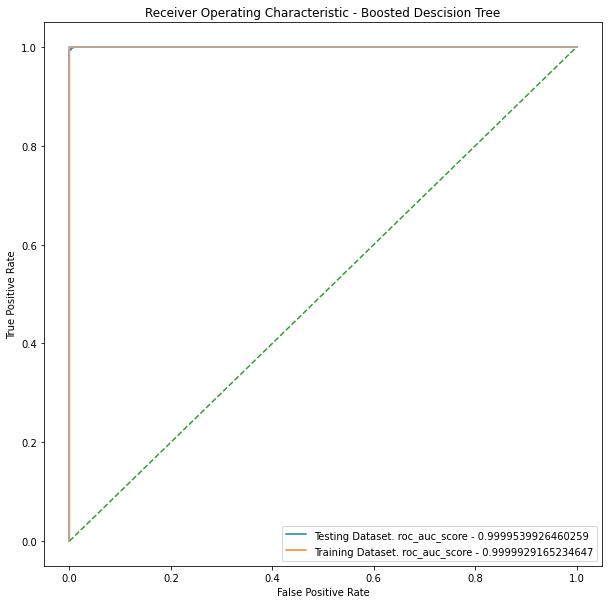

Model complete for, jpsi_mu_k_swap


C:\Windows\Temp\ipykernel_6392\1735490177.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dataset[range1]


['mu_minus_ProbNNpi', 'mu_minus_ProbNNmu', 'Pi_ProbNNpi', 'Pi_ProbNNmu', 'costhetal']


d:\Languages\Python\Python39\lib\site-packages\xgboost\core.py:568: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.55493
[1]	validation_0-logloss:0.43865
[2]	validation_0-logloss:0.34277
[3]	validation_0-logloss:0.26533
[4]	validation_0-logloss:0.20383
[5]	validation_0-logloss:0.15557
[6]	validation_0-logloss:0.11831
[7]	validation_0-logloss:0.08981
[8]	validation_0-logloss:0.06822
[9]	validation_0-logloss:0.05187
[10]	validation_0-logloss:0.03965
[11]	validation_0-logloss:0.03042
[12]	validation_0-logloss:0.02355
[13]	validation_0-logloss:0.01842
[14]	validation_0-logloss:0.01457
[15]	validation_0-logloss:0.01177
[16]	validation_0-logloss:0.00967
[17]	validation_0-logloss:0.00813
[18]	validation_0-logloss:0.00691
[19]	validation_0-logloss:0.00607
[20]	validation_0-logloss:0.00537
[21]	validation_0-logloss:0.00489
[22]	validation_0-logloss:0.00452
[23]	validation_0-logloss:0.00424
[24]	validation_0-logloss:0.00403
[25]	validation_0-logloss:0.00389
[26]	validation_0-logloss:0.00377
[27]	validation_0-logloss:0.00368
[28]	validation_0-logloss:0.00361
[29]	validation_0-loglos

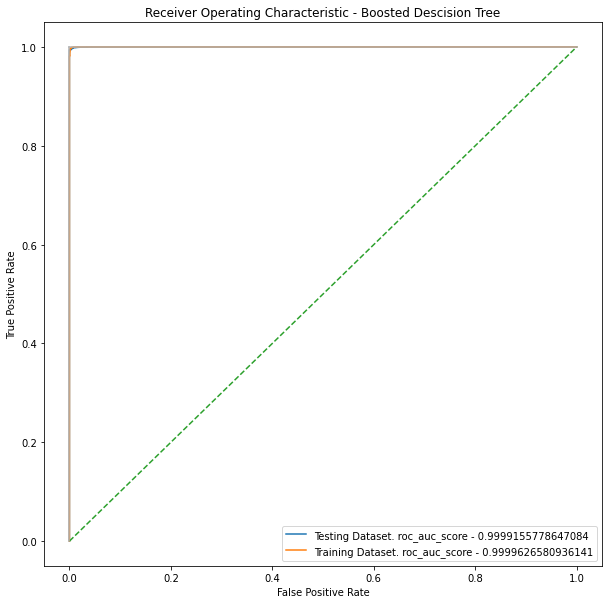

Model complete for, jpsi_mu_pi_swap


C:\Windows\Temp\ipykernel_6392\1735490177.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dataset[range1]


['K_ProbNNk', 'K_ProbNNpi', 'Pi_ProbNNk', 'Pi_ProbNNpi', 'Pi_ProbNNp']


d:\Languages\Python\Python39\lib\site-packages\xgboost\core.py:568: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.55915
[1]	validation_0-logloss:0.44668
[2]	validation_0-logloss:0.35436
[3]	validation_0-logloss:0.28003
[4]	validation_0-logloss:0.22101
[5]	validation_0-logloss:0.17513
[6]	validation_0-logloss:0.13982
[7]	validation_0-logloss:0.11280
[8]	validation_0-logloss:0.09242
[9]	validation_0-logloss:0.07712
[10]	validation_0-logloss:0.06571
[11]	validation_0-logloss:0.05729
[12]	validation_0-logloss:0.05108
[13]	validation_0-logloss:0.04640
[14]	validation_0-logloss:0.04304
[15]	validation_0-logloss:0.04050
[16]	validation_0-logloss:0.03868
[17]	validation_0-logloss:0.03728
[18]	validation_0-logloss:0.03635
[19]	validation_0-logloss:0.03571
[20]	validation_0-logloss:0.03521
[21]	validation_0-logloss:0.03488
[22]	validation_0-logloss:0.03455
[23]	validation_0-logloss:0.03434
[24]	validation_0-logloss:0.03418
[25]	validation_0-logloss:0.03404
[26]	validation_0-logloss:0.03397
[27]	validation_0-logloss:0.03390
[28]	validation_0-logloss:0.03384
[29]	validation_0-loglos

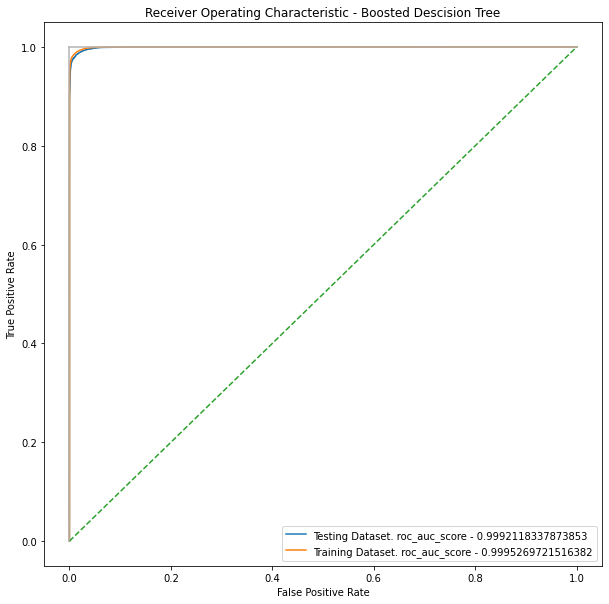

Model complete for, k_pi_swap


C:\Windows\Temp\ipykernel_6392\1735490177.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dataset[range1]


['Pi_ProbNNk', 'Pi_ProbNNpi', 'Pi_ProbNNp', 'Pi_PT', 'B0_M', 'Kstar_M', 'costhetak']


d:\Languages\Python\Python39\lib\site-packages\xgboost\core.py:568: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.55697
[1]	validation_0-logloss:0.44236
[2]	validation_0-logloss:0.34799
[3]	validation_0-logloss:0.27181
[4]	validation_0-logloss:0.21129
[5]	validation_0-logloss:0.16417
[6]	validation_0-logloss:0.12780
[7]	validation_0-logloss:0.09981
[8]	validation_0-logloss:0.07875
[9]	validation_0-logloss:0.06291
[10]	validation_0-logloss:0.05099
[11]	validation_0-logloss:0.04210
[12]	validation_0-logloss:0.03550
[13]	validation_0-logloss:0.03063
[14]	validation_0-logloss:0.02697
[15]	validation_0-logloss:0.02424
[16]	validation_0-logloss:0.02220
[17]	validation_0-logloss:0.02064
[18]	validation_0-logloss:0.01945
[19]	validation_0-logloss:0.01867
[20]	validation_0-logloss:0.01811
[21]	validation_0-logloss:0.01769
[22]	validation_0-logloss:0.01739
[23]	validation_0-logloss:0.01712
[24]	validation_0-logloss:0.01696
[25]	validation_0-logloss:0.01678
[26]	validation_0-logloss:0.01668
[27]	validation_0-logloss:0.01658
[28]	validation_0-logloss:0.01645
[29]	validation_0-loglos

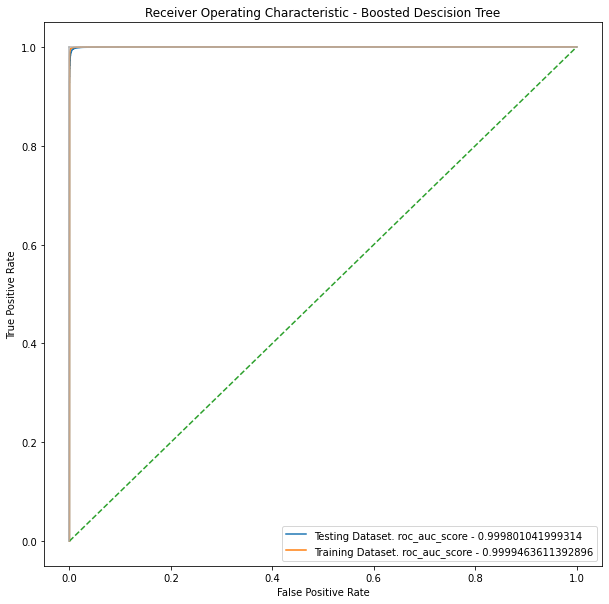

Model complete for, phimumu


C:\Windows\Temp\ipykernel_6392\1735490177.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dataset[range1]


['K_ProbNNk', 'K_ProbNNp', 'Pi_ProbNNk', 'Pi_ProbNNpi', 'B0_M', 'B0_OWNPV_Y']
[0]	validation_0-logloss:0.55675


d:\Languages\Python\Python39\lib\site-packages\xgboost\core.py:568: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-logloss:0.44196
[2]	validation_0-logloss:0.34728
[3]	validation_0-logloss:0.27084
[4]	validation_0-logloss:0.21005
[5]	validation_0-logloss:0.16239
[6]	validation_0-logloss:0.12535
[7]	validation_0-logloss:0.09699
[8]	validation_0-logloss:0.07522
[9]	validation_0-logloss:0.05875
[10]	validation_0-logloss:0.04636
[11]	validation_0-logloss:0.03701
[12]	validation_0-logloss:0.03006
[13]	validation_0-logloss:0.02483
[14]	validation_0-logloss:0.02090
[15]	validation_0-logloss:0.01786
[16]	validation_0-logloss:0.01559
[17]	validation_0-logloss:0.01401
[18]	validation_0-logloss:0.01277
[19]	validation_0-logloss:0.01181
[20]	validation_0-logloss:0.01111
[21]	validation_0-logloss:0.01062
[22]	validation_0-logloss:0.01015
[23]	validation_0-logloss:0.00991
[24]	validation_0-logloss:0.00966
[25]	validation_0-logloss:0.00942
[26]	validation_0-logloss:0.00931
[27]	validation_0-logloss:0.00924
[28]	validation_0-logloss:0.00913
[29]	validation_0-logloss:0.00910
[30]	validation_0-loglo

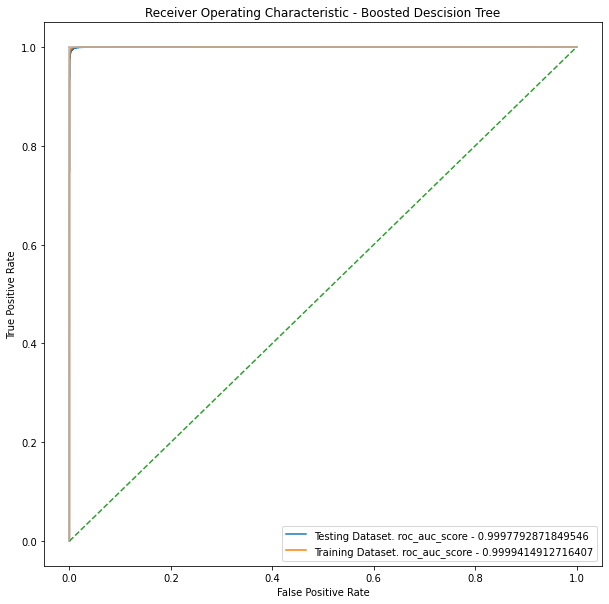

Model complete for, pKmumu_piTok_kTop


C:\Windows\Temp\ipykernel_6392\1735490177.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dataset[range1]


['Pi_ProbNNk', 'Pi_ProbNNpi', 'Pi_ProbNNp', 'Pi_P', 'Pi_PE', 'B0_M', 'Kstar_M', 'B0_OWNPV_Y']


d:\Languages\Python\Python39\lib\site-packages\xgboost\core.py:568: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.55655
[1]	validation_0-logloss:0.44160
[2]	validation_0-logloss:0.34681
[3]	validation_0-logloss:0.27019
[4]	validation_0-logloss:0.20918
[5]	validation_0-logloss:0.16159
[6]	validation_0-logloss:0.12465
[7]	validation_0-logloss:0.09650
[8]	validation_0-logloss:0.07511
[9]	validation_0-logloss:0.05895
[10]	validation_0-logloss:0.04687
[11]	validation_0-logloss:0.03759
[12]	validation_0-logloss:0.03072
[13]	validation_0-logloss:0.02559
[14]	validation_0-logloss:0.02177
[15]	validation_0-logloss:0.01896
[16]	validation_0-logloss:0.01689
[17]	validation_0-logloss:0.01536
[18]	validation_0-logloss:0.01416
[19]	validation_0-logloss:0.01326
[20]	validation_0-logloss:0.01263
[21]	validation_0-logloss:0.01210
[22]	validation_0-logloss:0.01171
[23]	validation_0-logloss:0.01140
[24]	validation_0-logloss:0.01117
[25]	validation_0-logloss:0.01113
[26]	validation_0-logloss:0.01101
[27]	validation_0-logloss:0.01088
[28]	validation_0-logloss:0.01077
[29]	validation_0-loglos

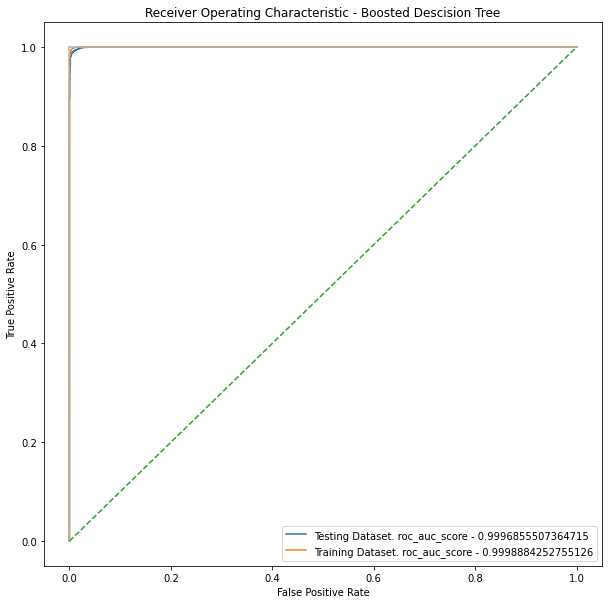

Model complete for, pKmumu_piTop


C:\Windows\Temp\ipykernel_6392\1735490177.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dataset[range1]


['Pi_PT', 'Pi_PX', 'Pi_IPCHI2_OWNPV', 'B0_M', 'B0_ENDVERTEX_CHI2', 'costhetak', 'B0_OWNPV_Y']


d:\Languages\Python\Python39\lib\site-packages\xgboost\core.py:568: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.55696
[1]	validation_0-logloss:0.44246
[2]	validation_0-logloss:0.34837
[3]	validation_0-logloss:0.27243
[4]	validation_0-logloss:0.21224
[5]	validation_0-logloss:0.16519
[6]	validation_0-logloss:0.12896
[7]	validation_0-logloss:0.10125
[8]	validation_0-logloss:0.08005
[9]	validation_0-logloss:0.06416
[10]	validation_0-logloss:0.05225
[11]	validation_0-logloss:0.04336
[12]	validation_0-logloss:0.03675
[13]	validation_0-logloss:0.03183
[14]	validation_0-logloss:0.02820
[15]	validation_0-logloss:0.02564
[16]	validation_0-logloss:0.02360
[17]	validation_0-logloss:0.02213
[18]	validation_0-logloss:0.02106
[19]	validation_0-logloss:0.02020
[20]	validation_0-logloss:0.01959
[21]	validation_0-logloss:0.01918
[22]	validation_0-logloss:0.01882
[23]	validation_0-logloss:0.01851
[24]	validation_0-logloss:0.01828
[25]	validation_0-logloss:0.01815
[26]	validation_0-logloss:0.01800
[27]	validation_0-logloss:0.01793
[28]	validation_0-logloss:0.01788
[29]	validation_0-loglos

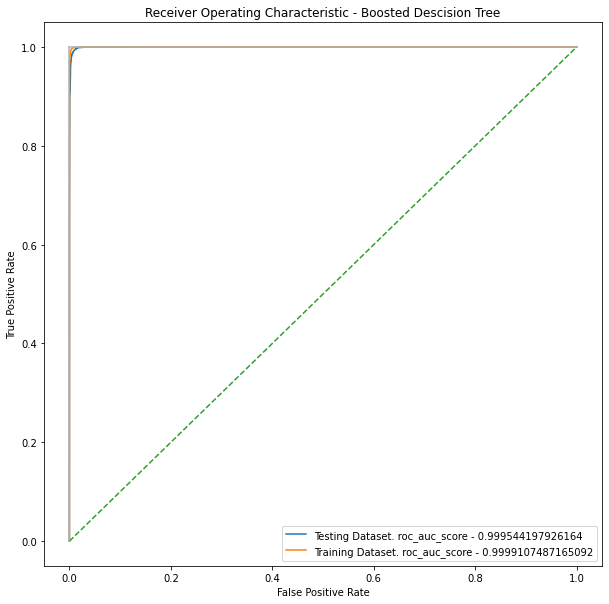

Model complete for, Kmumu


C:\Windows\Temp\ipykernel_6392\1735490177.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dataset[range1]


['Pi_PT', 'Pi_PX', 'Pi_IPCHI2_OWNPV', 'B0_M', 'B0_ENDVERTEX_CHI2', 'Kstar_M', 'Kstar_ENDVERTEX_CHI2']
[0]	validation_0-logloss:0.55834


d:\Languages\Python\Python39\lib\site-packages\xgboost\core.py:568: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-logloss:0.44533
[2]	validation_0-logloss:0.35267
[3]	validation_0-logloss:0.27767
[4]	validation_0-logloss:0.21834
[5]	validation_0-logloss:0.17154
[6]	validation_0-logloss:0.13554
[7]	validation_0-logloss:0.10805
[8]	validation_0-logloss:0.08706
[9]	validation_0-logloss:0.07124
[10]	validation_0-logloss:0.05926
[11]	validation_0-logloss:0.05034
[12]	validation_0-logloss:0.04357
[13]	validation_0-logloss:0.03875
[14]	validation_0-logloss:0.03520
[15]	validation_0-logloss:0.03258
[16]	validation_0-logloss:0.03057
[17]	validation_0-logloss:0.02907
[18]	validation_0-logloss:0.02814
[19]	validation_0-logloss:0.02724
[20]	validation_0-logloss:0.02659
[21]	validation_0-logloss:0.02614
[22]	validation_0-logloss:0.02594
[23]	validation_0-logloss:0.02573
[24]	validation_0-logloss:0.02555
[25]	validation_0-logloss:0.02545
[26]	validation_0-logloss:0.02533
[27]	validation_0-logloss:0.02519
[28]	validation_0-logloss:0.02513
[29]	validation_0-logloss:0.02512
[30]	validation_0-loglo

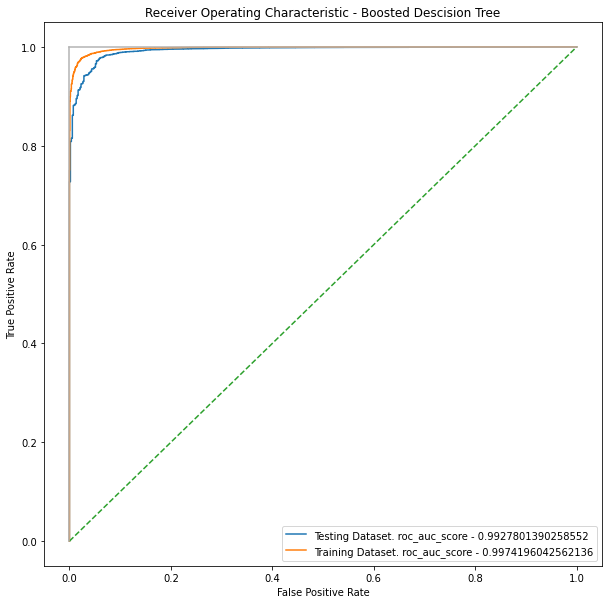

Model complete for, Kstarp_pi0


C:\Windows\Temp\ipykernel_6392\4205466757.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo_data.loc[:, "target"] = 0
C:\Windows\Temp\ipykernel_6392\1735490177.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dataset[range1]
d:\Languages\Python\Python39\lib\site-packages\xgboost\core.py:568: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
d:\Languages

[0]	validation_0-logloss:0.56373
[1]	validation_0-logloss:0.45573
[2]	validation_0-logloss:0.36701
[3]	validation_0-logloss:0.29564
[4]	validation_0-logloss:0.23945
[5]	validation_0-logloss:0.19520
[6]	validation_0-logloss:0.16140
[7]	validation_0-logloss:0.13564
[8]	validation_0-logloss:0.11656
[9]	validation_0-logloss:0.10191
[10]	validation_0-logloss:0.09150
[11]	validation_0-logloss:0.08318
[12]	validation_0-logloss:0.07719
[13]	validation_0-logloss:0.07256
[14]	validation_0-logloss:0.06909
[15]	validation_0-logloss:0.06675
[16]	validation_0-logloss:0.06497
[17]	validation_0-logloss:0.06340
[18]	validation_0-logloss:0.06243
[19]	validation_0-logloss:0.06140
[20]	validation_0-logloss:0.06073
[21]	validation_0-logloss:0.06022
[22]	validation_0-logloss:0.06001
[23]	validation_0-logloss:0.05976
[24]	validation_0-logloss:0.05938
[25]	validation_0-logloss:0.05919
[26]	validation_0-logloss:0.05903
[27]	validation_0-logloss:0.05895
[28]	validation_0-logloss:0.05874
[29]	validation_0-loglos

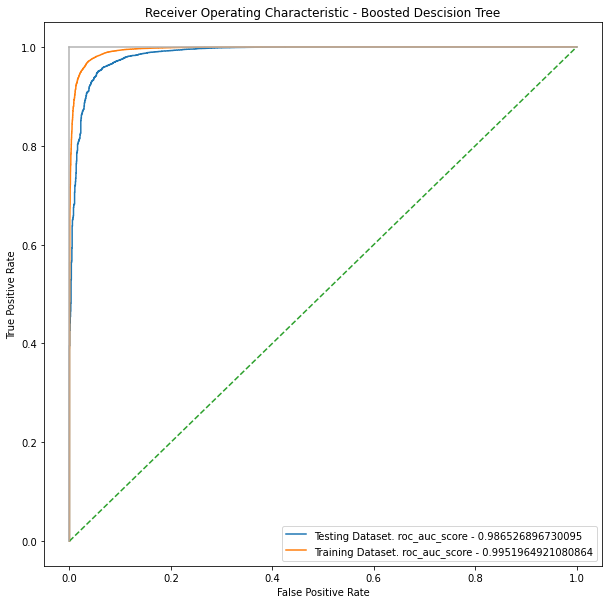

In [5]:
def remove_columns(dataset, reject_rows = []):
    #'B0_M', 'J_psi_M', 'q2','Kstar_M'
    dataset_modified = dataset.copy()
    dataset_modified.drop(columns=['Unnamed: 0.1','Unnamed: 0', 'year', 'B0_ID', 'B0_ENDVERTEX_NDOF','J_psi_ENDVERTEX_NDOF', 'Kstar_ENDVERTEX_NDOF'], inplace=True)
    if 'Unnamed: 0.2' in dataset_modified.columns:
        dataset_modified.drop(columns=['Unnamed: 0.2'], inplace=True)

    columns_list = dataset_modified.columns.tolist()
    for x in total_data.columns:
        if x in columns_list and x not in reject_rows:
            dataset_modified.drop(columns=[x],inplace = True)
    
    return dataset_modified

def train_model(X_train,y_train,X_test,y_test,name_of_model):
    model = xgb.XGBClassifier('binary:logistic', missing = np.nan, seed = 42, max_delta_step = 1)

    model.fit(X_train,
            y_train,
            verbose = True,
            early_stopping_rounds = 10,
            eval_metric = 'logloss',
            eval_set = [(X_test,y_test)]
            )

    model.save_model('Peaking_Models_Separate/peaking_model_'+name_of_model+'_removed_q2_range.model')
    
    print(X_train.columns)

    return model

def extract_combo_data(dataset, threshold):
    return dataset.loc[(dataset['B0_M'] > threshold)]

# TRAINING THE PEAKING MODEL
background_models = [jpsi_mu_k_swap,jpsi_mu_pi_swap,k_pi_swap,phimumu,pKmumu_piTok_kTop,pKmumu_piTop,Kmumu,Kstarp_pi0]
string_background_models = ['jpsi_mu_k_swap','jpsi_mu_pi_swap','k_pi_swap','phimumu','pKmumu_piTok_kTop','pKmumu_piTop','Kmumu','Kstarp_pi0']

signal.loc[:, "target"] = 1
signal = q2_ranges(signal)
for idx,x in enumerate(background_models):
    x.loc[:, "target"] = 0

    signal = q2_ranges(signal)
    x = q2_ranges(x)

    signal_clean = remove_columns(signal, RowRejector(string_background_models[idx]))
    background_clean = remove_columns(x, RowRejector(string_background_models[idx]))

    #We then combine the entire dataset.
    combine = pd.concat((signal_clean,background_clean), ignore_index=True, axis=0)
    #We then shuffle the order and relabel the index.
    combine = combine.sample(frac=1)
    combine = combine.reset_index(drop=True)



    #CREATING THE TRAINING AND TEST DATA
    seed = 42
    test_size = 0.2
    y = combine['target']
    X = combine.drop(columns=['target'])
    #Creating the three different data sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed, stratify = y)
    print(X_train.columns.tolist())
    model = train_model(X_train,y_train,X_test,y_test,string_background_models[idx])

    plt.subplots(1, figsize=(10,10))
    plt.title('Receiver Operating Characteristic - Boosted Descision Tree')
    y_score_test = model.predict_proba(X_test)[:,1]
    y_score_train = model.predict_proba(X_train)[:,1]
    false_positive_rate_test, true_positive_rate_test, threshold_train = roc_curve(y_test, y_score_test)
    false_positive_rate_train, true_positive_rate_train, threshold_train = roc_curve(y_train, y_score_train)
    plt.plot(false_positive_rate_test, true_positive_rate_test, label = "Testing Dataset. roc_auc_score - {}".format(roc_auc_score(y_test, y_score_test)))
    plt.plot(false_positive_rate_train, true_positive_rate_train, label = "Training Dataset. roc_auc_score - {}".format(roc_auc_score(y_train, y_score_train)))
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    plt.savefig("Overfitting_Graphs/Overfitting_separate_peaking_{}.jpg".format(string_background_models[idx]), bbox_inches="tight", pad_inches=0, format="jpg", dpi=600)
    plt.show()

    print("Model complete for,",string_background_models[idx])

    
def train_model(X_train,y_train,X_test,y_test):
    model = xgb.XGBClassifier('binary:logistic', missing = np.nan, seed = 42, max_delta_step = 1)

    model.fit(X_train,
            y_train,
            verbose = True,
            early_stopping_rounds = 10,
            eval_metric = 'logloss',
            eval_set = [(X_test,y_test)]
            )

    model.save_model('Comb_Model/comb_model_'+str(THRESHOLD)+'_removed_q2_range_29_features.model')

    return model

# TRAINING THE COMBO MODEL
THRESHOLD = 5350

combo_data = extract_combo_data(total_data,THRESHOLD)

combo_data.loc[:, "target"] = 0

signal = q2_ranges(signal)
combo_data = q2_ranges(combo_data)
signal_clean = remove_columns(signal, RowRejector("combo"))
combo_data_clean = remove_columns(combo_data, RowRejector("combo"))

#We then combine the entire dataset.
combine = pd.concat((signal_clean,combo_data_clean), ignore_index=True, axis=0)
#We then shuffle the order and relabel the index.
combine = combine.sample(frac=1)
combine = combine.reset_index(drop=True)



#CREATING THE TRAINING AND TEST DATA
seed = 42
test_size = 0.2
y = combine['target']
X = combine.drop(columns=['target'])
#Creating the three different data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed, stratify = y)
model = train_model(X_train,y_train,X_test,y_test)

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Boosted Descision Tree')
y_score_test = model.predict_proba(X_test)[:,1]
y_score_train = model.predict_proba(X_train)[:,1]
false_positive_rate_test, true_positive_rate_test, threshold_test = roc_curve(y_test, y_score_test)
false_positive_rate_train, true_positive_rate_train, threshold_train = roc_curve(y_train, y_score_train)
plt.plot(false_positive_rate_test, true_positive_rate_test, label = "Testing Dataset. roc_auc_score - {}".format(roc_auc_score(y_test, y_score_test)))
plt.plot(false_positive_rate_train, true_positive_rate_train, label = "Training Dataset. roc_auc_score - {}".format(roc_auc_score(y_train, y_score_train)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.savefig("Overfitting_Graphs/Overfitting_combo_graph.jpg", bbox_inches="tight", pad_inches=0, format="jpg", dpi=600)
plt.show()

In [32]:
#OPTIMISING PARAMETERS - COMB

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 42,
        'max_delta_step': 1
    }

# TRAINING THE COMBO MODEL
THRESHOLD = 5350

combo_data = extract_combo_data(total_data,THRESHOLD)

combo_data.loc[:, "target"] = 0

signal = q2_ranges(signal)
combo_data = q2_ranges(combo_data)
signal_clean = remove_columns(signal, RowRejector("combo"))
combo_data_clean = remove_columns(combo_data, RowRejector("combo"))

#We then combine the entire dataset.
combine = pd.concat((signal_clean,combo_data_clean), ignore_index=True, axis=0)
#We then shuffle the order and relabel the index.
combine = combine.sample(frac=1)
combine = combine.reset_index(drop=True)



#CREATING THE TRAINING AND TEST DATA
seed = 42
test_size = 0.2
y = combine['target']
X = combine.drop(columns=['target'])
#Creating the three different data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed, stratify = y)

def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    clf.fit(X_train, y_train,
            eval_set=[(X_test,y_test)], eval_metric="logloss",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }


trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

C:\Windows\Temp\ipykernel_6392\3940027305.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo_data.loc[:, "target"] = 0
C:\Windows\Temp\ipykernel_6392\1735490177.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dataset[range1]


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                 
0.9715328736310336                                     
  1%|          | 1/100 [00:11<19:45, 11.98s/trial, best loss: -0.9715328736310336]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9707216342785501                                                                
  2%|▏         | 2/100 [00:20<16:41, 10.22s/trial, best loss: -0.9715328736310336]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9703897636343523                                                                
  3%|▎         | 3/100 [00:29<15:38,  9.68s/trial, best loss: -0.9715328736310336]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9696153987978908                                                                
  4%|▍         | 4/100 [00:38<14:51,  9.29s/trial, best loss: -0.9715328736310336]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9703897636343523                                                                
  5%|▌         | 5/100 [00:47<14:20,  9.06s/trial, best loss: -0.9715328736310336]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9699103949260666                                                                
  6%|▌         | 6/100 [00:55<13:57,  8.91s/trial, best loss: -0.9715328736310336]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9714222500829677                                                                
  7%|▋         | 7/100 [01:05<14:12,  9.16s/trial, best loss: -0.9715328736310336]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9710903794387699                                                                
  8%|▊         | 8/100 [01:16<14:40,  9.57s/trial, best loss: -0.9715328736310336]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9710166304067259                                                                
  9%|▉         | 9/100 [01:24<14:12,  9.36s/trial, best loss: -0.9715328736310336]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.970758508794572                                                                 
 10%|█         | 10/100 [01:33<13:36,  9.08s/trial, best loss: -0.9715328736310336]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9715328736310336                                                                 
 11%|█         | 11/100 [01:43<13:48,  9.31s/trial, best loss: -0.9715328736310336]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9712378775028577                                                                 
 12%|█▏        | 12/100 [01:52<13:33,  9.25s/trial, best loss: -0.9715328736310336]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9702053910542424                                                                 
 13%|█▎        | 13/100 [02:00<12:57,  8.94s/trial, best loss: -0.9715328736310336]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9713853755669457                                                                 
 14%|█▍        | 14/100 [02:10<13:18,  9.29s/trial, best loss: -0.9715328736310336]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9714222500829677                                                                 
 15%|█▌        | 15/100 [02:19<12:57,  9.15s/trial, best loss: -0.9715328736310336]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9705003871824183                                                                 
 16%|█▌        | 16/100 [02:28<12:34,  8.98s/trial, best loss: -0.9715328736310336]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9729341052398687                                                                 
 17%|█▋        | 17/100 [02:39<13:33,  9.80s/trial, best loss: -0.9729341052398687]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9698735204100446                                                                 
 18%|█▊        | 18/100 [02:48<12:46,  9.34s/trial, best loss: -0.9729341052398687]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9695416497658468                                                                 
 19%|█▉        | 19/100 [02:56<12:18,  9.12s/trial, best loss: -0.9729341052398687]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9707216342785501                                                                 
 20%|██        | 20/100 [03:05<11:54,  8.94s/trial, best loss: -0.9729341052398687]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9728603562078247                                                                 
 21%|██        | 21/100 [03:16<12:48,  9.73s/trial, best loss: -0.9729341052398687]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9728234816918028                                                                 
 22%|██▏       | 22/100 [03:28<13:22, 10.29s/trial, best loss: -0.9729341052398687]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9733028504000885                                                                 
 23%|██▎       | 23/100 [03:39<13:42, 10.68s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9722703639514731                                                                 
 24%|██▍       | 24/100 [03:49<13:14, 10.46s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9721228658873853                                                                 
 25%|██▌       | 25/100 [04:00<13:00, 10.41s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9717909952431875                                                                 
 26%|██▌       | 26/100 [04:10<12:53, 10.45s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9728603562078247                                                                 
 27%|██▋       | 27/100 [04:22<13:11, 10.85s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9713116265349018                                                                 
 28%|██▊       | 28/100 [04:31<12:25, 10.35s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9717172462111435                                                                 
 29%|██▉       | 29/100 [04:41<12:06, 10.23s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.97090600685866                                                                   
 30%|███       | 30/100 [04:49<11:07,  9.54s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.972380987499539                                                                  
 31%|███       | 31/100 [05:00<11:28,  9.98s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9717541207271655                                                                 
 32%|███▏      | 32/100 [05:09<10:51,  9.59s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9713853755669457                                                                 
 33%|███▎      | 33/100 [05:18<10:44,  9.62s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9717909952431875                                                                 
 34%|███▍      | 34/100 [05:29<10:48,  9.82s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.972528485563627                                                                  
 35%|███▌      | 35/100 [05:40<10:58, 10.13s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.970832257826616                                                                  
 36%|███▌      | 36/100 [05:48<10:24,  9.75s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9714591245989896                                                                 
 37%|███▋      | 37/100 [05:58<10:09,  9.67s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9713853755669457                                                                 
 38%|███▊      | 38/100 [06:08<10:04,  9.75s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9714222500829677                                                                 
 39%|███▉      | 39/100 [06:17<09:48,  9.65s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9728972307238467                                                                 
 40%|████      | 40/100 [06:28<10:02, 10.05s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9730816033039567                                                                 
 41%|████      | 41/100 [06:40<10:20, 10.51s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9710166304067259                                                                 
 42%|████▏     | 42/100 [06:50<09:54, 10.25s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9711272539547918                                                                 
 43%|████▎     | 43/100 [06:59<09:23,  9.89s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9703528891183303                                                                 
 44%|████▍     | 44/100 [07:07<08:52,  9.52s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9706847597625281                                                                 
 45%|████▌     | 45/100 [07:16<08:35,  9.37s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9713485010509237                                                                 
 46%|████▌     | 46/100 [07:26<08:38,  9.61s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9698735204100446                                                                 
 47%|████▋     | 47/100 [07:35<08:11,  9.28s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9721966149194292                                                                 
 48%|████▊     | 48/100 [07:46<08:31,  9.84s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9713853755669457                                                                 
 49%|████▉     | 49/100 [07:56<08:21,  9.83s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9711272539547918                                                                 
 50%|█████     | 50/100 [08:05<08:03,  9.68s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9717541207271655                                                                 
 51%|█████     | 51/100 [08:16<08:05,  9.91s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9716434971790995                                                                 
 52%|█████▏    | 52/100 [08:26<07:59, 10.00s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9705741362144622                                                                 
 53%|█████▎    | 53/100 [08:35<07:32,  9.62s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9700947675061765                                                                 
 54%|█████▍    | 54/100 [08:43<07:12,  9.40s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9721228658873853                                                                 
 55%|█████▌    | 55/100 [08:54<07:23,  9.86s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9710166304067259                                                                 
 56%|█████▌    | 56/100 [09:04<07:07,  9.71s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9713485010509237                                                                 
 57%|█████▋    | 57/100 [09:13<06:48,  9.49s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.972491611047605                                                                  
 58%|█████▊    | 58/100 [09:24<07:00, 10.02s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9706110107304842                                                                 
 59%|█████▉    | 59/100 [09:33<06:40,  9.77s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9706478852465061                                                                 
 60%|██████    | 60/100 [09:42<06:20,  9.51s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9718647442752314                                                                 
 61%|██████    | 61/100 [09:52<06:17,  9.69s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.970942881374682                                                                  
 62%|██████▏   | 62/100 [10:00<05:47,  9.15s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9726759836277149                                                                 
 63%|██████▎   | 63/100 [10:11<06:00,  9.74s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9714591245989896                                                                 
 64%|██████▍   | 64/100 [10:22<05:57,  9.93s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9714591245989896                                                                 
 65%|██████▌   | 65/100 [10:31<05:47,  9.93s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9721597404034072                                                                 
 66%|██████▌   | 66/100 [10:42<05:47, 10.21s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9730816033039567                                                                 
 67%|██████▋   | 67/100 [10:55<05:58, 10.85s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9718647442752314                                                                 
 68%|██████▊   | 68/100 [11:08<06:06, 11.45s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9729709797558908                                                                 
 69%|██████▉   | 69/100 [11:19<05:58, 11.55s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9721597404034072                                                                 
 70%|███████   | 70/100 [11:30<05:42, 11.42s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9726391091116929                                                                 
 71%|███████   | 71/100 [11:42<05:34, 11.52s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9697997713780007                                                                 
 72%|███████▏  | 72/100 [11:50<04:55, 10.55s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9713116265349018                                                                 
 73%|███████▎  | 73/100 [12:01<04:43, 10.51s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9719384933072753                                                                 
 74%|███████▍  | 74/100 [12:12<04:35, 10.60s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9717541207271655                                                                 
 75%|███████▌  | 75/100 [12:22<04:22, 10.50s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9721228658873853                                                                 
 76%|███████▌  | 76/100 [12:33<04:17, 10.72s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9699103949260666                                                                 
 77%|███████▋  | 77/100 [12:42<03:51, 10.07s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.972565360079649                                                                  
 78%|███████▊  | 78/100 [12:54<03:56, 10.75s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9713116265349018                                                                 
 79%|███████▉  | 79/100 [13:04<03:40, 10.48s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9712747520188798                                                                 
 80%|████████  | 80/100 [13:13<03:23, 10.20s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9716066226630775                                                                 
 81%|████████  | 81/100 [13:24<03:13, 10.18s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9727497326597588                                                                 
 82%|████████▏ | 82/100 [13:36<03:14, 10.79s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.970979755890704                                                                  
 83%|████████▎ | 83/100 [13:45<02:57, 10.42s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9720122423393193                                                                 
 84%|████████▍ | 84/100 [13:57<02:50, 10.64s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9716803716951214                                                                 
 85%|████████▌ | 85/100 [14:06<02:32, 10.19s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9730078542719127                                                                 
 86%|████████▌ | 86/100 [14:20<02:39, 11.38s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9720491168553412                                                                 
 87%|████████▋ | 87/100 [14:31<02:26, 11.28s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9716066226630775                                                                 
 88%|████████▊ | 88/100 [14:41<02:11, 10.99s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.970758508794572                                                                  
 89%|████████▉ | 89/100 [14:50<01:52, 10.24s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.972491611047605                                                                  
 90%|█████████ | 90/100 [15:01<01:45, 10.54s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9702422655702644                                                                 
 91%|█████████ | 91/100 [15:09<01:29,  9.89s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9716803716951214                                                                 
 92%|█████████▏| 92/100 [15:20<01:20, 10.09s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9713116265349018                                                                 
 93%|█████████▎| 93/100 [15:29<01:09,  9.89s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.970758508794572                                                                  
 94%|█████████▍| 94/100 [15:39<00:58,  9.71s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9714222500829677                                                                 
 95%|█████████▌| 95/100 [15:48<00:48,  9.62s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9715328736310336                                                                 
 96%|█████████▌| 96/100 [15:58<00:38,  9.69s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9701685165382204                                                                 
 97%|█████████▋| 97/100 [16:06<00:27,  9.30s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.970979755890704                                                                  
 98%|█████████▊| 98/100 [16:15<00:18,  9.21s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9717172462111435                                                                 
 99%|█████████▉| 99/100 [16:25<00:09,  9.41s/trial, best loss: -0.9733028504000885]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9711641284708138                                                                 
100%|██████████| 100/100 [16:34<00:00,  9.95s/trial, best loss: -0.9733028504000885]


In [34]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.7069505447985888, 'gamma': 1.0513705037261616, 'max_depth': 6.0, 'min_child_weight': 0.0, 'reg_alpha': 41.0, 'reg_lambda': 0.6127807031221809}


In [39]:
best_hyperparams['n_estimators'] = 180
best_hyperparams['seed'] = 42
best_hyperparams['max_delta_step'] = 1

with open('Optimized_Parameters/comb.json', 'w') as f:
    json.dump(best_hyperparams, f)

In [42]:
f = open('Optimized_Parameters/comb.json')
best_hyperparams = json.load(f)
best_hyperparams

{'colsample_bytree': 0.7069505447985888,
 'gamma': 1.0513705037261616,
 'max_depth': 6.0,
 'min_child_weight': 0.0,
 'reg_alpha': 41.0,
 'reg_lambda': 0.6127807031221809,
 'n_estimators': 180,
 'seed': 42,
 'max_delta_step': 1}

C:\Windows\Temp\ipykernel_6392\1458074137.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo_data.loc[:, "target"] = 0
C:\Windows\Temp\ipykernel_6392\1735490177.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dataset[range1]
d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_pa

[0]	validation_0-logloss:0.56403
[1]	validation_0-logloss:0.45599
[2]	validation_0-logloss:0.36793
[3]	validation_0-logloss:0.29701
[4]	validation_0-logloss:0.24155
[5]	validation_0-logloss:0.20308
[6]	validation_0-logloss:0.16920
[7]	validation_0-logloss:0.14269
[8]	validation_0-logloss:0.12284
[9]	validation_0-logloss:0.10861
[10]	validation_0-logloss:0.09740
[11]	validation_0-logloss:0.08906
[12]	validation_0-logloss:0.08343
[13]	validation_0-logloss:0.07870
[14]	validation_0-logloss:0.07505
[15]	validation_0-logloss:0.07227
[16]	validation_0-logloss:0.07007
[17]	validation_0-logloss:0.06859
[18]	validation_0-logloss:0.06719
[19]	validation_0-logloss:0.06613
[20]	validation_0-logloss:0.06540
[21]	validation_0-logloss:0.06424
[22]	validation_0-logloss:0.06363
[23]	validation_0-logloss:0.06318
[24]	validation_0-logloss:0.06288
[25]	validation_0-logloss:0.06254
[26]	validation_0-logloss:0.06219
[27]	validation_0-logloss:0.06163
[28]	validation_0-logloss:0.06142
[29]	validation_0-loglos

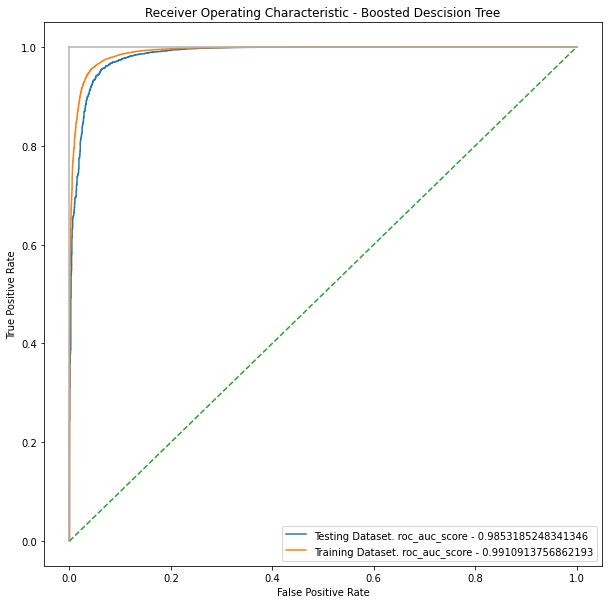

In [43]:
# Rerunning Comb model

def train_model(X_train,y_train,X_test,y_test):
    f = open('Optimized_Parameters/comb.json')
    best_hyperparams = json.load(f)
    best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])
    model = xgb.XGBClassifier(**best_hyperparams)

    model.fit(X_train,
            y_train,
            verbose = True,
            early_stopping_rounds = 10,
            eval_metric = 'logloss',
            eval_set = [(X_test,y_test)]
            )

    model.save_model('Comb_Model/comb_model_'+str(THRESHOLD)+'_removed_q2_range_29_features.model')

    return model

# TRAINING THE COMBO MODEL
THRESHOLD = 5350

combo_data = extract_combo_data(total_data,THRESHOLD)

combo_data.loc[:, "target"] = 0

signal = q2_ranges(signal)
combo_data = q2_ranges(combo_data)
signal_clean = remove_columns(signal, RowRejector("combo"))
combo_data_clean = remove_columns(combo_data, RowRejector("combo"))

#We then combine the entire dataset.
combine = pd.concat((signal_clean,combo_data_clean), ignore_index=True, axis=0)
#We then shuffle the order and relabel the index.
combine = combine.sample(frac=1)
combine = combine.reset_index(drop=True)



#CREATING THE TRAINING AND TEST DATA
seed = 42
test_size = 0.2
y = combine['target']
X = combine.drop(columns=['target'])
#Creating the three different data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed, stratify = y)
model = train_model(X_train,y_train,X_test,y_test)

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Boosted Descision Tree')
y_score_test = model.predict_proba(X_test)[:,1]
y_score_train = model.predict_proba(X_train)[:,1]
false_positive_rate_test, true_positive_rate_test, threshold_test = roc_curve(y_test, y_score_test)
false_positive_rate_train, true_positive_rate_train, threshold_train = roc_curve(y_train, y_score_train)
plt.plot(false_positive_rate_test, true_positive_rate_test, label = "Testing Dataset. roc_auc_score - {}".format(roc_auc_score(y_test, y_score_test)))
plt.plot(false_positive_rate_train, true_positive_rate_train, label = "Training Dataset. roc_auc_score - {}".format(roc_auc_score(y_train, y_score_train)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.savefig("Overfitting_Graphs_Optimized/Overfitting_combo_graph.jpg", bbox_inches="tight", pad_inches=0, format="jpg", dpi=600)
plt.show()

In [48]:
# Optmisation - Peaking

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 42,
        'max_delta_step': 1
    }

def remove_columns(dataset, reject_rows = []):
    #'B0_M', 'J_psi_M', 'q2','Kstar_M'
    dataset_modified = dataset.copy()
    dataset_modified.drop(columns=['Unnamed: 0.1','Unnamed: 0', 'year', 'B0_ID', 'B0_ENDVERTEX_NDOF','J_psi_ENDVERTEX_NDOF', 'Kstar_ENDVERTEX_NDOF'], inplace=True)
    if 'Unnamed: 0.2' in dataset_modified.columns:
        dataset_modified.drop(columns=['Unnamed: 0.2'], inplace=True)

    columns_list = dataset_modified.columns.tolist()
    for x in total_data.columns:
        if x in columns_list and x not in reject_rows:
            dataset_modified.drop(columns=[x],inplace = True)
    
    return dataset_modified

def train_model(X_train,y_train,X_test,y_test,name_of_model):
    model = xgb.XGBClassifier('binary:logistic', missing = np.nan, seed = 42, max_delta_step = 1)

    model.fit(X_train,
            y_train,
            verbose = True,
            early_stopping_rounds = 10,
            eval_metric = 'logloss',
            eval_set = [(X_test,y_test)]
            )

    model.save_model('Peaking_Models_Separate/peaking_model_'+name_of_model+'_removed_q2_range.model')
    
    print(X_train.columns)

    return model


# TRAINING THE PEAKING MODEL
background_models = [jpsi_mu_k_swap,jpsi_mu_pi_swap,k_pi_swap,phimumu,pKmumu_piTok_kTop,pKmumu_piTop,Kmumu,Kstarp_pi0]
string_background_models = ['jpsi_mu_k_swap','jpsi_mu_pi_swap','k_pi_swap','phimumu','pKmumu_piTok_kTop','pKmumu_piTop','Kmumu','Kstarp_pi0']

signal.loc[:, "target"] = 1
signal = q2_ranges(signal)
for idx,x in enumerate(background_models):
    x.loc[:, "target"] = 0
    x = q2_ranges(x)

    signal_clean = remove_columns(signal, RowRejector(string_background_models[idx]))
    background_clean = remove_columns(x, RowRejector(string_background_models[idx]))

    #We then combine the entire dataset.
    combine = pd.concat((signal_clean,background_clean), ignore_index=True, axis=0)
    #We then shuffle the order and relabel the index.
    combine = combine.sample(frac=1)
    combine = combine.reset_index(drop=True)



    #CREATING THE TRAINING AND TEST DATA
    seed = 42
    test_size = 0.2
    y = combine['target']
    X = combine.drop(columns=['target'])
    #Creating the three different data sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed, stratify = y)

    def objective(space):
        clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
        clf.fit(X_train, y_train,
                eval_set=[(X_test,y_test)], eval_metric="logloss",
                early_stopping_rounds=10,verbose=False)
        

        pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, pred>0.5)
        print ("SCORE:", accuracy)
        return {'loss': -accuracy, 'status': STATUS_OK }

    trials = Trials()

    best_hyperparams = fmin(fn = objective,
                    space = space,
                    algo = tpe.suggest,
                    max_evals = 100,
                    trials = trials)

    best_hyperparams['n_estimators'] = 180
    best_hyperparams['seed'] = 42
    best_hyperparams['max_delta_step'] = 1

    with open('Optimized_Parameters/{}.json'.format(string_background_models[idx]), 'w') as f:
        json.dump(best_hyperparams, f)
        

    print("Accuracy complete for,",string_background_models[idx])


C:\Windows\Temp\ipykernel_6392\1735490177.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dataset[range1]


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                 
0.9982089319783515                                     
  1%|          | 1/100 [00:01<02:26,  1.48s/trial, best loss: -0.9982089319783515]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9976638243195889                                                                
  2%|▏         | 2/100 [00:02<02:14,  1.37s/trial, best loss: -0.9982089319783515]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9987540396371141                                                                
  3%|▎         | 3/100 [00:04<02:37,  1.62s/trial, best loss: -0.9987540396371141]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9978585056262897                                                                
  4%|▍         | 4/100 [00:06<02:35,  1.62s/trial, best loss: -0.9987540396371141]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9978195693649495                                                                
  5%|▌         | 5/100 [00:07<02:34,  1.63s/trial, best loss: -0.9987540396371141]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9973912704902075                                                                
  6%|▌         | 6/100 [00:09<02:25,  1.55s/trial, best loss: -0.9987540396371141]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9985982945917533                                                                
  7%|▋         | 7/100 [00:11<02:34,  1.67s/trial, best loss: -0.9987540396371141]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.998325740762372                                                                 
  8%|▊         | 8/100 [00:13<02:35,  1.70s/trial, best loss: -0.9987540396371141]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9986761671144336                                                                
  9%|▉         | 9/100 [00:15<02:46,  1.83s/trial, best loss: -0.9987540396371141]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.998131059455671                                                                 
 10%|█         | 10/100 [00:16<02:39,  1.78s/trial, best loss: -0.9987540396371141]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9984814858077328                                                                 
 11%|█         | 11/100 [00:18<02:43,  1.84s/trial, best loss: -0.9987540396371141]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9982478682396916                                                                 
 12%|█▏        | 12/100 [00:20<02:41,  1.84s/trial, best loss: -0.9987540396371141]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9983646770237122                                                                 
 13%|█▎        | 13/100 [00:22<02:39,  1.84s/trial, best loss: -0.9987540396371141]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.998325740762372                                                                  
 14%|█▍        | 14/100 [00:24<02:37,  1.83s/trial, best loss: -0.9987540396371141]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9986372308530935                                                                 
 15%|█▌        | 15/100 [00:26<02:38,  1.86s/trial, best loss: -0.9987540396371141]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9987151033757738                                                                 
 16%|█▌        | 16/100 [00:28<02:41,  1.93s/trial, best loss: -0.9987540396371141]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9982478682396916                                                                 
 17%|█▋        | 17/100 [00:29<02:33,  1.85s/trial, best loss: -0.9987540396371141]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9981699957170113                                                                 
 18%|█▊        | 18/100 [00:31<02:29,  1.82s/trial, best loss: -0.9987540396371141]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.998131059455671                                                                  
 19%|█▉        | 19/100 [00:33<02:25,  1.80s/trial, best loss: -0.9987540396371141]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9983646770237122                                                                 
 20%|██        | 20/100 [00:35<02:25,  1.81s/trial, best loss: -0.9987540396371141]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9987151033757738                                                                 
 21%|██        | 21/100 [00:37<02:30,  1.91s/trial, best loss: -0.9987540396371141]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9984814858077328                                                                 
 22%|██▏       | 22/100 [00:39<02:28,  1.91s/trial, best loss: -0.9987540396371141]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9986372308530935                                                                 
 23%|██▎       | 23/100 [00:41<02:29,  1.94s/trial, best loss: -0.9987540396371141]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9987151033757738                                                                 
 24%|██▍       | 24/100 [00:43<02:30,  1.98s/trial, best loss: -0.9987540396371141]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9984425495463926                                                                 
 25%|██▌       | 25/100 [00:45<02:26,  1.96s/trial, best loss: -0.9987540396371141]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9988319121597944                                                                 
 26%|██▌       | 26/100 [00:47<02:29,  2.02s/trial, best loss: -0.9988319121597944]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9985593583304131                                                                 
 27%|██▋       | 27/100 [00:49<02:28,  2.04s/trial, best loss: -0.9988319121597944]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9988708484211346                                                                 
 28%|██▊       | 28/100 [00:51<02:29,  2.08s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9985204220690729                                                                 
 29%|██▉       | 29/100 [00:53<02:23,  2.02s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9986372308530935                                                                 
 30%|███       | 30/100 [00:55<02:21,  2.02s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9988708484211346                                                                 
 31%|███       | 31/100 [00:57<02:23,  2.08s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.998131059455671                                                                  
 32%|███▏      | 32/100 [00:59<02:16,  2.01s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9984425495463926                                                                 
 33%|███▎      | 33/100 [01:01<02:14,  2.01s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9976638243195889                                                                 
 34%|███▍      | 34/100 [01:03<02:07,  1.93s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9980921231943308                                                                 
 35%|███▌      | 35/100 [01:05<02:00,  1.85s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9987151033757738                                                                 
 36%|███▌      | 36/100 [01:07<02:03,  1.93s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9974302067515477                                                                 
 37%|███▋      | 37/100 [01:08<01:53,  1.80s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9986761671144336                                                                 
 38%|███▊      | 38/100 [01:10<01:57,  1.90s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9982868045010318                                                                 
 39%|███▉      | 39/100 [01:12<01:54,  1.88s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9986761671144336                                                                 
 40%|████      | 40/100 [01:14<01:59,  1.99s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9984814858077328                                                                 
 41%|████      | 41/100 [01:16<01:57,  1.98s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9987540396371141                                                                 
 42%|████▏     | 42/100 [01:19<01:58,  2.05s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.998325740762372                                                                  
 43%|████▎     | 43/100 [01:20<01:53,  2.00s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9978585056262897                                                                 
 44%|████▍     | 44/100 [01:22<01:46,  1.90s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9984814858077328                                                                 
 45%|████▌     | 45/100 [01:24<01:46,  1.94s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9986761671144336                                                                 
 46%|████▌     | 46/100 [01:26<01:48,  2.01s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9984036132850523                                                                 
 47%|████▋     | 47/100 [01:28<01:46,  2.00s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9973912704902075                                                                 
 48%|████▊     | 48/100 [01:30<01:39,  1.92s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9987151033757738                                                                 
 49%|████▉     | 49/100 [01:32<01:40,  1.96s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9985982945917533                                                                 
 50%|█████     | 50/100 [01:34<01:38,  1.97s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9984036132850523                                                                 
 51%|█████     | 51/100 [01:36<01:36,  1.96s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9982478682396916                                                                 
 52%|█████▏    | 52/100 [01:38<01:32,  1.92s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9978195693649495                                                                 
 53%|█████▎    | 53/100 [01:40<01:26,  1.85s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9982868045010318                                                                 
 54%|█████▍    | 54/100 [01:42<01:26,  1.87s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9987151033757738                                                                 
 55%|█████▌    | 55/100 [01:44<01:29,  1.99s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9986372308530935                                                                 
 56%|█████▌    | 56/100 [01:46<01:27,  2.00s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9980921231943308                                                                 
 57%|█████▋    | 57/100 [01:47<01:21,  1.89s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9978585056262897                                                                 
 58%|█████▊    | 58/100 [01:49<01:18,  1.86s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.998131059455671                                                                  
 59%|█████▉    | 59/100 [01:51<01:15,  1.83s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9985982945917533                                                                 
 60%|██████    | 60/100 [01:53<01:16,  1.92s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9988708484211346                                                                 
 61%|██████    | 61/100 [01:55<01:17,  1.99s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9986761671144336                                                                 
 62%|██████▏   | 62/100 [01:57<01:15,  2.00s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9982478682396916                                                                 
 63%|██████▎   | 63/100 [01:59<01:11,  1.93s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9984814858077328                                                                 
 64%|██████▍   | 64/100 [02:01<01:10,  1.95s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.998325740762372                                                                  
 65%|██████▌   | 65/100 [02:03<01:07,  1.92s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9988708484211346                                                                 
 66%|██████▌   | 66/100 [02:05<01:07,  1.99s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9988319121597944                                                                 
 67%|██████▋   | 67/100 [02:07<01:07,  2.03s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9987151033757738                                                                 
 68%|██████▊   | 68/100 [02:09<01:06,  2.09s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9988319121597944                                                                 
 69%|██████▉   | 69/100 [02:12<01:05,  2.10s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9987151033757738                                                                 
 70%|███████   | 70/100 [02:14<01:02,  2.10s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9988319121597944                                                                 
 71%|███████   | 71/100 [02:16<01:01,  2.12s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9984814858077328                                                                 
 72%|███████▏  | 72/100 [02:18<00:57,  2.06s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9983646770237122                                                                 
 73%|███████▎  | 73/100 [02:20<00:54,  2.02s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9986372308530935                                                                 
 74%|███████▍  | 74/100 [02:22<00:54,  2.08s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9986761671144336                                                                 
 75%|███████▌  | 75/100 [02:24<00:51,  2.04s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9984425495463926                                                                 
 76%|███████▌  | 76/100 [02:26<00:48,  2.03s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9987151033757738                                                                 
 77%|███████▋  | 77/100 [02:28<00:48,  2.09s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9985982945917533                                                                 
 78%|███████▊  | 78/100 [02:30<00:45,  2.06s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9987151033757738                                                                 
 79%|███████▉  | 79/100 [02:32<00:43,  2.07s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9987929758984543                                                                 
 80%|████████  | 80/100 [02:34<00:42,  2.13s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9987151033757738                                                                 
 81%|████████  | 81/100 [02:36<00:40,  2.12s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9982478682396916                                                                 
 82%|████████▏ | 82/100 [02:38<00:36,  2.04s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9984036132850523                                                                 
 83%|████████▎ | 83/100 [02:40<00:33,  2.00s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.998325740762372                                                                  
 84%|████████▍ | 84/100 [02:42<00:31,  1.95s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9976638243195889                                                                 
 85%|████████▌ | 85/100 [02:44<00:29,  1.94s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9984814858077328                                                                 
 86%|████████▌ | 86/100 [02:46<00:27,  1.95s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9987151033757738                                                                 
 87%|████████▋ | 87/100 [02:48<00:25,  1.98s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9984814858077328                                                                 
 88%|████████▊ | 88/100 [02:50<00:24,  2.00s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9987151033757738                                                                 
 89%|████████▉ | 89/100 [02:52<00:22,  2.01s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9986372308530935                                                                 
 90%|█████████ | 90/100 [02:54<00:20,  2.05s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9987151033757738                                                                 
 91%|█████████ | 91/100 [02:56<00:18,  2.09s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9984425495463926                                                                 
 92%|█████████▏| 92/100 [02:58<00:16,  2.08s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9984814858077328                                                                 
 93%|█████████▎| 93/100 [03:00<00:14,  2.06s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.998325740762372                                                                  
 94%|█████████▍| 94/100 [03:02<00:12,  2.03s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9986761671144336                                                                 
 95%|█████████▌| 95/100 [03:05<00:10,  2.04s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9987151033757738                                                                 
 96%|█████████▌| 96/100 [03:07<00:08,  2.04s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9987151033757738                                                                 
 97%|█████████▋| 97/100 [03:09<00:06,  2.08s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.998131059455671                                                                  
 98%|█████████▊| 98/100 [03:11<00:04,  2.00s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.99789744188763                                                                   
 99%|█████████▉| 99/100 [03:12<00:01,  1.93s/trial, best loss: -0.9988708484211346]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9976638243195889                                                                 
100%|██████████| 100/100 [03:14<00:00,  1.94s/trial, best loss: -0.9988708484211346]
Accuracy complete for, jpsi_mu_k_swap


C:\Windows\Temp\ipykernel_6392\1735490177.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dataset[range1]


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                 
0.9972545531881984                                     
  1%|          | 1/100 [00:01<03:12,  1.94s/trial, best loss: -0.9972545531881984]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9974092262480182                                                                
  2%|▏         | 2/100 [00:03<03:15,  1.99s/trial, best loss: -0.9974092262480182]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9970612118634237                                                                
  3%|▎         | 3/100 [00:05<03:13,  2.00s/trial, best loss: -0.9974092262480182]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9977959088975678                                                                
  4%|▍         | 4/100 [00:08<03:18,  2.06s/trial, best loss: -0.9977959088975678]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9972158849232435                                                                
  5%|▌         | 5/100 [00:10<03:14,  2.04s/trial, best loss: -0.9977959088975678]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.997602567572793                                                                 
  6%|▌         | 6/100 [00:12<03:13,  2.05s/trial, best loss: -0.9977959088975678]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9973318897181084                                                                
  7%|▋         | 7/100 [00:14<03:09,  2.04s/trial, best loss: -0.9977959088975678]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9973318897181084                                                                
  8%|▊         | 8/100 [00:16<03:04,  2.00s/trial, best loss: -0.9977959088975678]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9975638993078381                                                                
  9%|▉         | 9/100 [00:18<03:03,  2.02s/trial, best loss: -0.9977959088975678]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.997641235837748                                                                 
 10%|█         | 10/100 [00:20<03:05,  2.06s/trial, best loss: -0.9977959088975678]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9975638993078381                                                                 
 11%|█         | 11/100 [00:22<03:02,  2.05s/trial, best loss: -0.9977959088975678]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9972932214531534                                                                 
 12%|█▏        | 12/100 [00:24<03:00,  2.05s/trial, best loss: -0.9977959088975678]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9975638993078381                                                                 
 13%|█▎        | 13/100 [00:26<02:56,  2.03s/trial, best loss: -0.9977959088975678]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9973705579830633                                                                 
 14%|█▍        | 14/100 [00:28<02:55,  2.04s/trial, best loss: -0.9977959088975678]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.997641235837748                                                                  
 15%|█▌        | 15/100 [00:30<02:55,  2.06s/trial, best loss: -0.9977959088975678]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9979505819573876                                                                 
 16%|█▌        | 16/100 [00:33<03:02,  2.18s/trial, best loss: -0.9979505819573876]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9976799041027029                                                                 
 17%|█▋        | 17/100 [00:35<02:57,  2.14s/trial, best loss: -0.9979505819573876]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9973318897181084                                                                 
 18%|█▊        | 18/100 [00:37<02:53,  2.11s/trial, best loss: -0.9979505819573876]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9970998801283787                                                                 
 19%|█▉        | 19/100 [00:39<02:47,  2.06s/trial, best loss: -0.9979505819573876]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9973705579830633                                                                 
 20%|██        | 20/100 [00:41<02:45,  2.07s/trial, best loss: -0.9979505819573876]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9979119136924326                                                                 
 21%|██        | 21/100 [00:43<02:51,  2.17s/trial, best loss: -0.9979505819573876]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9979119136924326                                                                 
 22%|██▏       | 22/100 [00:45<02:53,  2.22s/trial, best loss: -0.9979505819573876]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9978732454274777                                                                 
 23%|██▎       | 23/100 [00:48<02:55,  2.27s/trial, best loss: -0.9979505819573876]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9977959088975678                                                                 
 24%|██▍       | 24/100 [00:50<02:53,  2.29s/trial, best loss: -0.9979505819573876]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9978732454274777                                                                 
 25%|██▌       | 25/100 [00:52<02:50,  2.28s/trial, best loss: -0.9979505819573876]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9975638993078381                                                                 
 26%|██▌       | 26/100 [00:54<02:44,  2.22s/trial, best loss: -0.9979505819573876]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9977959088975678                                                                 
 27%|██▋       | 27/100 [00:57<02:43,  2.24s/trial, best loss: -0.9979505819573876]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9980665867522525                                                                 
 28%|██▊       | 28/100 [00:59<02:47,  2.33s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9974478945129732                                                                 
 29%|██▉       | 29/100 [01:01<02:41,  2.27s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9977959088975678                                                                 
 30%|███       | 30/100 [01:04<02:37,  2.25s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9977572406326128                                                                 
 31%|███       | 31/100 [01:06<02:35,  2.25s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9975638993078381                                                                 
 32%|███▏      | 32/100 [01:08<02:29,  2.21s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.997602567572793                                                                  
 33%|███▎      | 33/100 [01:10<02:28,  2.22s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9979119136924326                                                                 
 34%|███▍      | 34/100 [01:13<02:30,  2.28s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9974092262480182                                                                 
 35%|███▌      | 35/100 [01:15<02:24,  2.22s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9977959088975678                                                                 
 36%|███▌      | 36/100 [01:17<02:21,  2.21s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9978345771625227                                                                 
 37%|███▋      | 37/100 [01:19<02:19,  2.21s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9974865627779281                                                                 
 38%|███▊      | 38/100 [01:21<02:15,  2.18s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.997641235837748                                                                  
 39%|███▉      | 39/100 [01:23<02:11,  2.15s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9977572406326128                                                                 
 40%|████      | 40/100 [01:25<02:07,  2.13s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9975638993078381                                                                 
 41%|████      | 41/100 [01:28<02:06,  2.14s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9978345771625227                                                                 
 42%|████▏     | 42/100 [01:30<02:08,  2.21s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9975638993078381                                                                 
 43%|████▎     | 43/100 [01:32<02:04,  2.19s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9979119136924326                                                                 
 44%|████▍     | 44/100 [01:34<02:05,  2.24s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.997641235837748                                                                  
 45%|████▌     | 45/100 [01:37<02:01,  2.21s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9974865627779281                                                                 
 46%|████▌     | 46/100 [01:39<01:56,  2.15s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9970612118634237                                                                 
 47%|████▋     | 47/100 [01:41<01:52,  2.13s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.997602567572793                                                                  
 48%|████▊     | 48/100 [01:43<01:49,  2.11s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.997602567572793                                                                  
 49%|████▉     | 49/100 [01:45<01:48,  2.12s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9972545531881984                                                                 
 50%|█████     | 50/100 [01:47<01:46,  2.13s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9972932214531534                                                                 
 51%|█████     | 51/100 [01:49<01:43,  2.11s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9972158849232435                                                                 
 52%|█████▏    | 52/100 [01:51<01:40,  2.10s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.997641235837748                                                                  
 53%|█████▎    | 53/100 [01:53<01:39,  2.12s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9977959088975678                                                                 
 54%|█████▍    | 54/100 [01:56<01:38,  2.15s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9979892502223425                                                                 
 55%|█████▌    | 55/100 [01:58<01:39,  2.21s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9979892502223425                                                                 
 56%|█████▌    | 56/100 [02:00<01:40,  2.29s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9977572406326128                                                                 
 57%|█████▋    | 57/100 [02:03<01:38,  2.30s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.997641235837748                                                                  
 58%|█████▊    | 58/100 [02:05<01:35,  2.29s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9978732454274777                                                                 
 59%|█████▉    | 59/100 [02:07<01:35,  2.34s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9974865627779281                                                                 
 60%|██████    | 60/100 [02:09<01:29,  2.23s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9977185723676578                                                                 
 61%|██████    | 61/100 [02:12<01:26,  2.21s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9975638993078381                                                                 
 62%|██████▏   | 62/100 [02:14<01:23,  2.20s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.997602567572793                                                                  
 63%|██████▎   | 63/100 [02:16<01:21,  2.19s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.997602567572793                                                                  
 64%|██████▍   | 64/100 [02:18<01:19,  2.20s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9974478945129732                                                                 
 65%|██████▌   | 65/100 [02:20<01:15,  2.16s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9979892502223425                                                                 
 66%|██████▌   | 66/100 [02:23<01:17,  2.27s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9980279184872974                                                                 
 67%|██████▋   | 67/100 [02:25<01:15,  2.30s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9977572406326128                                                                 
 68%|██████▊   | 68/100 [02:27<01:13,  2.30s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9977185723676578                                                                 
 69%|██████▉   | 69/100 [02:30<01:11,  2.30s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9977959088975678                                                                 
 70%|███████   | 70/100 [02:32<01:09,  2.30s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9974092262480182                                                                 
 71%|███████   | 71/100 [02:34<01:05,  2.26s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9979119136924326                                                                 
 72%|███████▏  | 72/100 [02:37<01:04,  2.31s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9978732454274777                                                                 
 73%|███████▎  | 73/100 [02:39<01:02,  2.32s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9977185723676578                                                                 
 74%|███████▍  | 74/100 [02:41<00:59,  2.29s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9979119136924326                                                                 
 75%|███████▌  | 75/100 [02:44<00:57,  2.32s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9978732454274777                                                                 
 76%|███████▌  | 76/100 [02:46<00:55,  2.29s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9975638993078381                                                                 
 77%|███████▋  | 77/100 [02:48<00:52,  2.28s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9979119136924326                                                                 
 78%|███████▊  | 78/100 [02:50<00:50,  2.31s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9976799041027029                                                                 
 79%|███████▉  | 79/100 [02:53<00:48,  2.33s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9970612118634237                                                                 
 80%|████████  | 80/100 [02:55<00:44,  2.21s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.997602567572793                                                                  
 81%|████████  | 81/100 [02:57<00:42,  2.24s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9978345771625227                                                                 
 82%|████████▏ | 82/100 [02:59<00:40,  2.27s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9978345771625227                                                                 
 83%|████████▎ | 83/100 [03:02<00:38,  2.26s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9975252310428832                                                                 
 84%|████████▍ | 84/100 [03:04<00:35,  2.22s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9972932214531534                                                                 
 85%|████████▌ | 85/100 [03:06<00:32,  2.18s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.997602567572793                                                                  
 86%|████████▌ | 86/100 [03:08<00:30,  2.21s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9977185723676578                                                                 
 87%|████████▋ | 87/100 [03:10<00:28,  2.23s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.997602567572793                                                                  
 88%|████████▊ | 88/100 [03:13<00:26,  2.21s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9978732454274777                                                                 
 89%|████████▉ | 89/100 [03:15<00:24,  2.26s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9977959088975678                                                                 
 90%|█████████ | 90/100 [03:17<00:22,  2.27s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9977185723676578                                                                 
 91%|█████████ | 91/100 [03:19<00:20,  2.25s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9974478945129732                                                                 
 92%|█████████▏| 92/100 [03:22<00:17,  2.24s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9975638993078381                                                                 
 93%|█████████▎| 93/100 [03:24<00:15,  2.23s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9970998801283787                                                                 
 94%|█████████▍| 94/100 [03:26<00:12,  2.14s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9972932214531534                                                                 
 95%|█████████▌| 95/100 [03:28<00:10,  2.13s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.997602567572793                                                                  
 96%|█████████▌| 96/100 [03:30<00:08,  2.15s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9979119136924326                                                                 
 97%|█████████▋| 97/100 [03:33<00:06,  2.24s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.997602567572793                                                                  
 98%|█████████▊| 98/100 [03:35<00:04,  2.23s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9975638993078381                                                                 
 99%|█████████▉| 99/100 [03:37<00:02,  2.23s/trial, best loss: -0.9980665867522525]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9977959088975678                                                                 
100%|██████████| 100/100 [03:39<00:00,  2.20s/trial, best loss: -0.9980665867522525]
Accuracy complete for, jpsi_mu_pi_swap


C:\Windows\Temp\ipykernel_6392\1735490177.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dataset[range1]


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                 
0.9850208117924654                                     
  1%|          | 1/100 [00:06<10:11,  6.18s/trial, best loss: -0.9850208117924654]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9848617407672525                                                                
  2%|▏         | 2/100 [00:12<09:48,  6.01s/trial, best loss: -0.9850208117924654]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9847026697420398                                                                
  3%|▎         | 3/100 [00:17<09:25,  5.83s/trial, best loss: -0.9850208117924654]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9853389538428908                                                                
  4%|▍         | 4/100 [00:24<10:04,  6.29s/trial, best loss: -0.9853389538428908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9851533709801427                                                                
  5%|▌         | 5/100 [00:32<11:03,  6.98s/trial, best loss: -0.9853389538428908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9850738354675362                                                                
  6%|▌         | 6/100 [00:39<10:31,  6.72s/trial, best loss: -0.9853389538428908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9851268591426072                                                                
  7%|▋         | 7/100 [00:46<10:34,  6.82s/trial, best loss: -0.9853389538428908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9848617407672525                                                                
  8%|▊         | 8/100 [00:52<10:18,  6.72s/trial, best loss: -0.9853389538428908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9848352289297171                                                                
  9%|▉         | 9/100 [00:58<09:42,  6.41s/trial, best loss: -0.9853389538428908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9844640632042206                                                                
 10%|█         | 10/100 [01:03<09:11,  6.13s/trial, best loss: -0.9853389538428908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9846231342294335                                                                 
 11%|█         | 11/100 [01:09<08:50,  5.96s/trial, best loss: -0.9853389538428908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9853654656804263                                                                 
 12%|█▏        | 12/100 [01:16<09:24,  6.42s/trial, best loss: -0.9853654656804263]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9848882526047881                                                                 
 13%|█▎        | 13/100 [01:21<08:36,  5.94s/trial, best loss: -0.9853654656804263]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9846761579045044                                                                 
 14%|█▍        | 14/100 [01:27<08:19,  5.81s/trial, best loss: -0.9853654656804263]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9847822052546462                                                                 
 15%|█▌        | 15/100 [01:32<08:09,  5.76s/trial, best loss: -0.9853654656804263]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9854450011930327                                                                 
 16%|█▌        | 16/100 [01:39<08:33,  6.11s/trial, best loss: -0.9854450011930327]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9854715130305681                                                                 
 17%|█▋        | 17/100 [01:46<08:39,  6.25s/trial, best loss: -0.9854715130305681]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9847291815795752                                                                 
 18%|█▊        | 18/100 [01:53<08:44,  6.39s/trial, best loss: -0.9854715130305681]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9847026697420398                                                                 
 19%|█▉        | 19/100 [01:58<08:15,  6.12s/trial, best loss: -0.9854715130305681]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9846496460669689                                                                 
 20%|██        | 20/100 [02:03<07:52,  5.90s/trial, best loss: -0.9854715130305681]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9853654656804263                                                                 
 21%|██        | 21/100 [02:11<08:15,  6.28s/trial, best loss: -0.9854715130305681]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9852063946552135                                                                 
 22%|██▏       | 22/100 [02:17<08:13,  6.32s/trial, best loss: -0.9854715130305681]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9854184893554973                                                                 
 23%|██▎       | 23/100 [02:24<08:23,  6.53s/trial, best loss: -0.9854715130305681]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9851798828176781                                                                 
 24%|██▍       | 24/100 [02:31<08:27,  6.68s/trial, best loss: -0.9854715130305681]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9854450011930327                                                                 
 25%|██▌       | 25/100 [02:38<08:35,  6.87s/trial, best loss: -0.9854715130305681]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9854980248681036                                                                 
 26%|██▌       | 26/100 [02:46<08:47,  7.13s/trial, best loss: -0.9854980248681036]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9849677881173944                                                                 
 27%|██▋       | 27/100 [02:53<08:26,  6.94s/trial, best loss: -0.9854980248681036]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.985232906492749                                                                  
 28%|██▊       | 28/100 [03:00<08:21,  6.96s/trial, best loss: -0.9854980248681036]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9849942999549299                                                                 
 29%|██▉       | 29/100 [03:06<07:58,  6.74s/trial, best loss: -0.9854980248681036]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.985232906492749                                                                  
 30%|███       | 30/100 [03:13<07:49,  6.71s/trial, best loss: -0.9854980248681036]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9854980248681036                                                                 
 31%|███       | 31/100 [03:21<08:25,  7.32s/trial, best loss: -0.9854980248681036]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9856040722182454                                                                 
 32%|███▏      | 32/100 [03:31<08:57,  7.91s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.98528593016782                                                                   
 33%|███▎      | 33/100 [03:38<08:41,  7.78s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9853919775179618                                                                 
 34%|███▍      | 34/100 [03:46<08:44,  7.94s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9853919775179618                                                                 
 35%|███▌      | 35/100 [03:55<08:44,  8.07s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9849677881173944                                                                 
 36%|███▌      | 36/100 [04:01<08:01,  7.52s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9850473236300008                                                                 
 37%|███▋      | 37/100 [04:07<07:25,  7.07s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9851533709801427                                                                 
 38%|███▊      | 38/100 [04:14<07:10,  6.94s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9853124420053554                                                                 
 39%|███▉      | 39/100 [04:21<07:05,  6.98s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9854980248681036                                                                 
 40%|████      | 40/100 [04:28<07:08,  7.14s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9847291815795752                                                                 
 41%|████      | 41/100 [04:35<06:46,  6.88s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9851268591426072                                                                 
 42%|████▏     | 42/100 [04:41<06:34,  6.80s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9851268591426072                                                                 
 43%|████▎     | 43/100 [04:48<06:24,  6.74s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9851003473050717                                                                 
 44%|████▍     | 44/100 [04:55<06:24,  6.87s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9854715130305681                                                                 
 45%|████▌     | 45/100 [05:05<07:18,  7.97s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9854184893554973                                                                 
 46%|████▌     | 46/100 [05:13<07:11,  7.98s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9849677881173944                                                                 
 47%|████▋     | 47/100 [05:19<06:29,  7.35s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9854980248681036                                                                 
 48%|████▊     | 48/100 [05:28<06:49,  7.88s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9853124420053554                                                                 
 49%|████▉     | 49/100 [05:35<06:28,  7.63s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9847822052546462                                                                 
 50%|█████     | 50/100 [05:41<05:49,  6.99s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9855245367056391                                                                 
 51%|█████     | 51/100 [05:49<05:54,  7.23s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9853124420053554                                                                 
 52%|█████▏    | 52/100 [05:57<06:01,  7.54s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9849677881173944                                                                 
 53%|█████▎    | 53/100 [06:04<05:49,  7.44s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9850208117924654                                                                 
 54%|█████▍    | 54/100 [06:11<05:29,  7.17s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9848352289297171                                                                 
 55%|█████▌    | 55/100 [06:18<05:18,  7.07s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9854450011930327                                                                 
 56%|█████▌    | 56/100 [06:27<05:41,  7.75s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9847291815795752                                                                 
 57%|█████▋    | 57/100 [06:33<05:12,  7.27s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9851533709801427                                                                 
 58%|█████▊    | 58/100 [06:40<04:54,  7.02s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9849677881173944                                                                 
 59%|█████▉    | 59/100 [06:45<04:29,  6.57s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9853124420053554                                                                 
 60%|██████    | 60/100 [06:51<04:18,  6.47s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9847026697420398                                                                 
 61%|██████    | 61/100 [06:57<04:05,  6.29s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9854450011930327                                                                 
 62%|██████▏   | 62/100 [07:07<04:34,  7.22s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9854715130305681                                                                 
 63%|██████▎   | 63/100 [07:15<04:35,  7.46s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9849147644423235                                                                 
 64%|██████▍   | 64/100 [07:21<04:17,  7.14s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9848882526047881                                                                 
 65%|██████▌   | 65/100 [07:27<03:58,  6.82s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9854715130305681                                                                 
 66%|██████▌   | 66/100 [07:36<04:13,  7.45s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9854184893554973                                                                 
 67%|██████▋   | 67/100 [07:44<04:15,  7.73s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9854715130305681                                                                 
 68%|██████▊   | 68/100 [07:52<04:06,  7.71s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9849942999549299                                                                 
 69%|██████▉   | 69/100 [07:58<03:47,  7.33s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9851798828176781                                                                 
 70%|███████   | 70/100 [08:05<03:37,  7.25s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9853124420053554                                                                 
 71%|███████   | 71/100 [08:13<03:36,  7.47s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9854184893554973                                                                 
 72%|███████▏  | 72/100 [08:22<03:39,  7.83s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9851798828176781                                                                 
 73%|███████▎  | 73/100 [08:29<03:26,  7.65s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9854184893554973                                                                 
 74%|███████▍  | 74/100 [08:39<03:31,  8.13s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9854184893554973                                                                 
 75%|███████▌  | 75/100 [08:47<03:22,  8.10s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9853654656804263                                                                 
 76%|███████▌  | 76/100 [08:54<03:08,  7.84s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9853654656804263                                                                 
 77%|███████▋  | 77/100 [09:02<03:04,  8.01s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9850738354675362                                                                 
 78%|███████▊  | 78/100 [09:09<02:45,  7.53s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9853919775179618                                                                 
 79%|███████▉  | 79/100 [09:16<02:34,  7.36s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9850473236300008                                                                 
 80%|████████  | 80/100 [09:22<02:20,  7.04s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9855245367056391                                                                 
 81%|████████  | 81/100 [09:31<02:25,  7.68s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.98528593016782                                                                   
 82%|████████▏ | 82/100 [09:39<02:19,  7.74s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9854450011930327                                                                 
 83%|████████▎ | 83/100 [09:49<02:24,  8.53s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9856040722182454                                                                 
 84%|████████▍ | 84/100 [09:58<02:17,  8.61s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.985232906492749                                                                  
 85%|████████▌ | 85/100 [10:06<02:07,  8.49s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9848352289297171                                                                 
 86%|████████▌ | 86/100 [10:13<01:49,  7.84s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9853919775179618                                                                 
 87%|████████▋ | 87/100 [10:22<01:45,  8.14s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9849942999549299                                                                 
 88%|████████▊ | 88/100 [10:29<01:35,  7.95s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9853919775179618                                                                 
 89%|████████▉ | 89/100 [10:36<01:24,  7.69s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.98557756038071                                                                   
 90%|█████████ | 90/100 [10:45<01:19,  7.98s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9848087170921817                                                                 
 91%|█████████ | 91/100 [10:50<01:05,  7.28s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9846761579045044                                                                 
 92%|█████████▏| 92/100 [10:56<00:54,  6.86s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9854450011930327                                                                 
 93%|█████████▎| 93/100 [11:05<00:51,  7.31s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.98557756038071                                                                   
 94%|█████████▍| 94/100 [11:12<00:43,  7.32s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9849942999549299                                                                 
 95%|█████████▌| 95/100 [11:18<00:34,  6.96s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9854184893554973                                                                 
 96%|█████████▌| 96/100 [11:26<00:28,  7.18s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9851798828176781                                                                 
 97%|█████████▋| 97/100 [11:33<00:21,  7.03s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9847291815795752                                                                 
 98%|█████████▊| 98/100 [11:38<00:13,  6.55s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9846231342294335                                                                 
 99%|█████████▉| 99/100 [11:43<00:06,  6.20s/trial, best loss: -0.9856040722182454]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9853919775179618                                                                 
100%|██████████| 100/100 [11:52<00:00,  7.12s/trial, best loss: -0.9856040722182454]
Accuracy complete for, k_pi_swap


C:\Windows\Temp\ipykernel_6392\1735490177.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dataset[range1]


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                 
0.9938817671363492                                     
  1%|          | 1/100 [00:08<13:45,  8.33s/trial, best loss: -0.9938817671363492]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9935109651446128                                                                
  2%|▏         | 2/100 [00:14<11:50,  7.25s/trial, best loss: -0.9938817671363492]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9933785358618498                                                                
  3%|▎         | 3/100 [00:21<11:27,  7.08s/trial, best loss: -0.9938817671363492]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9938023095666914                                                                
  4%|▍         | 4/100 [00:29<11:49,  7.40s/trial, best loss: -0.9938817671363492]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9935639368577179                                                                
  5%|▌         | 5/100 [00:36<11:24,  7.20s/trial, best loss: -0.9938817671363492]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9934844792880602                                                                
  6%|▌         | 6/100 [00:43<11:07,  7.11s/trial, best loss: -0.9938817671363492]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9939082529929018                                                                
  7%|▋         | 7/100 [00:51<11:42,  7.56s/trial, best loss: -0.9939082529929018]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9936698802839283                                                                
  8%|▊         | 8/100 [00:59<11:28,  7.48s/trial, best loss: -0.9939082529929018]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9937228519970336                                                                
  9%|▉         | 9/100 [01:07<11:38,  7.68s/trial, best loss: -0.9939082529929018]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9936698802839283                                                                
 10%|█         | 10/100 [01:14<11:09,  7.44s/trial, best loss: -0.9939082529929018]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9938817671363492                                                                 
 11%|█         | 11/100 [01:22<11:17,  7.62s/trial, best loss: -0.9939082529929018]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9935904227142706                                                                 
 12%|█▏        | 12/100 [01:29<10:59,  7.49s/trial, best loss: -0.9939082529929018]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9935904227142706                                                                 
 13%|█▎        | 13/100 [01:36<10:31,  7.26s/trial, best loss: -0.9939082529929018]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9936433944273758                                                                 
 14%|█▍        | 14/100 [01:42<10:07,  7.07s/trial, best loss: -0.9939082529929018]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9936169085708232                                                                 
 15%|█▌        | 15/100 [01:49<10:01,  7.08s/trial, best loss: -0.9939082529929018]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9935904227142706                                                                 
 16%|█▌        | 16/100 [01:56<09:49,  7.02s/trial, best loss: -0.9939082529929018]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9935374510011654                                                                 
 17%|█▋        | 17/100 [02:03<09:36,  6.94s/trial, best loss: -0.9939082529929018]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9936169085708232                                                                 
 18%|█▊        | 18/100 [02:10<09:30,  6.96s/trial, best loss: -0.9939082529929018]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.993961224706007                                                                  
 19%|█▉        | 19/100 [02:22<11:15,  8.34s/trial, best loss: -0.993961224706007] 

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9938817671363492                                                                
 20%|██        | 20/100 [02:30<11:07,  8.34s/trial, best loss: -0.993961224706007]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9940406822756648                                                                
 21%|██        | 21/100 [02:39<11:06,  8.43s/trial, best loss: -0.9940406822756648]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9942525691280856                                                                 
 22%|██▏       | 22/100 [02:48<11:19,  8.71s/trial, best loss: -0.9942525691280856]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9941466257018752                                                                 
 23%|██▎       | 23/100 [02:57<11:26,  8.92s/trial, best loss: -0.9942525691280856]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9941731115584278                                                                 
 24%|██▍       | 24/100 [03:07<11:34,  9.14s/trial, best loss: -0.9942525691280856]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9941466257018752                                                                 
 25%|██▌       | 25/100 [03:17<11:35,  9.27s/trial, best loss: -0.9942525691280856]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9937228519970336                                                                 
 26%|██▌       | 26/100 [03:24<10:54,  8.84s/trial, best loss: -0.9942525691280856]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9937758237101388                                                                 
 27%|██▋       | 27/100 [03:33<10:37,  8.73s/trial, best loss: -0.9942525691280856]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9940406822756648                                                                 
 28%|██▊       | 28/100 [03:42<10:39,  8.88s/trial, best loss: -0.9942525691280856]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9938817671363492                                                                 
 29%|██▉       | 29/100 [03:51<10:20,  8.74s/trial, best loss: -0.9942525691280856]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9937228519970336                                                                 
 30%|███       | 30/100 [03:59<09:57,  8.54s/trial, best loss: -0.9942525691280856]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9943055408411908                                                                 
 31%|███       | 31/100 [04:13<11:51, 10.30s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9938817671363492                                                                 
 32%|███▏      | 32/100 [04:22<11:10,  9.86s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.993696366140481                                                                  
 33%|███▎      | 33/100 [04:30<10:21,  9.27s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9939877105625596                                                                 
 34%|███▍      | 34/100 [04:43<11:28, 10.43s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9939082529929018                                                                 
 35%|███▌      | 35/100 [04:52<10:45,  9.93s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9938817671363492                                                                 
 36%|███▌      | 36/100 [05:00<10:06,  9.48s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9940671681322174                                                                 
 37%|███▋      | 37/100 [05:09<09:48,  9.35s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9937758237101388                                                                 
 38%|███▊      | 38/100 [05:19<09:48,  9.49s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9939082529929018                                                                 
 39%|███▉      | 39/100 [05:28<09:31,  9.37s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9936433944273758                                                                 
 40%|████      | 40/100 [05:35<08:42,  8.70s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9937228519970336                                                                 
 41%|████      | 41/100 [05:43<08:17,  8.44s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9937493378535862                                                                 
 42%|████▏     | 42/100 [05:54<08:52,  9.18s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9934844792880602                                                                 
 43%|████▎     | 43/100 [06:01<08:05,  8.52s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9938817671363492                                                                 
 44%|████▍     | 44/100 [06:09<07:54,  8.47s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9942525691280856                                                                 
 45%|████▌     | 45/100 [06:19<08:06,  8.84s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.993828795423244                                                                  
 46%|████▌     | 46/100 [06:27<07:49,  8.69s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9942260832715331                                                                 
 47%|████▋     | 47/100 [06:40<08:50, 10.01s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9936169085708232                                                                 
 48%|████▊     | 48/100 [06:48<08:02,  9.28s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9937228519970336                                                                 
 49%|████▉     | 49/100 [06:56<07:28,  8.80s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9936698802839283                                                                 
 50%|█████     | 50/100 [07:04<07:14,  8.69s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.99409365398877                                                                   
 51%|█████     | 51/100 [07:13<07:17,  8.92s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9939347388494544                                                                 
 52%|█████▏    | 52/100 [07:22<06:59,  8.74s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9939082529929018                                                                 
 53%|█████▎    | 53/100 [07:31<06:57,  8.88s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9936698802839283                                                                 
 54%|█████▍    | 54/100 [07:38<06:26,  8.40s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9938023095666914                                                                 
 55%|█████▌    | 55/100 [07:47<06:20,  8.46s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9936169085708232                                                                 
 56%|█████▌    | 56/100 [07:54<05:51,  7.99s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.99409365398877                                                                   
 57%|█████▋    | 57/100 [08:03<05:59,  8.35s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9938817671363492                                                                 
 58%|█████▊    | 58/100 [08:11<05:52,  8.39s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9935904227142706                                                                 
 59%|█████▉    | 59/100 [08:19<05:33,  8.14s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9938817671363492                                                                 
 60%|██████    | 60/100 [08:27<05:28,  8.21s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9935374510011654                                                                 
 61%|██████    | 61/100 [08:35<05:16,  8.10s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9939082529929018                                                                 
 62%|██████▏   | 62/100 [08:49<06:17,  9.94s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9937758237101388                                                                 
 63%|██████▎   | 63/100 [08:59<06:02,  9.79s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9935109651446128                                                                 
 64%|██████▍   | 64/100 [09:07<05:32,  9.25s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9937493378535862                                                                 
 65%|██████▌   | 65/100 [09:16<05:18,  9.11s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9942260832715331                                                                 
 66%|██████▌   | 66/100 [09:29<05:48, 10.24s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9941995974149804                                                                 
 67%|██████▋   | 67/100 [09:42<06:06, 11.12s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9941466257018752                                                                 
 68%|██████▊   | 68/100 [09:52<05:51, 10.99s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9941466257018752                                                                 
 69%|██████▉   | 69/100 [10:03<05:33, 10.76s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9939082529929018                                                                 
 70%|███████   | 70/100 [10:12<05:12, 10.41s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.993961224706007                                                                  
 71%|███████   | 71/100 [10:22<04:52, 10.09s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9938817671363492                                                                 
 72%|███████▏  | 72/100 [10:31<04:34,  9.79s/trial, best loss: -0.9943055408411908]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9943320266977435                                                                 
 73%|███████▎  | 73/100 [10:43<04:41, 10.43s/trial, best loss: -0.9943320266977435]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.993828795423244                                                                  
 74%|███████▍  | 74/100 [10:53<04:32, 10.47s/trial, best loss: -0.9943320266977435]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9941201398453225                                                                 
 75%|███████▌  | 75/100 [11:03<04:16, 10.25s/trial, best loss: -0.9943320266977435]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9938552812797966                                                                 
 76%|███████▌  | 76/100 [11:12<03:54,  9.78s/trial, best loss: -0.9943320266977435]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.993961224706007                                                                  
 77%|███████▋  | 77/100 [11:21<03:45,  9.82s/trial, best loss: -0.9943320266977435]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9941731115584278                                                                 
 78%|███████▊  | 78/100 [11:34<03:52, 10.59s/trial, best loss: -0.9943320266977435]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9941201398453225                                                                 
 79%|███████▉  | 79/100 [11:44<03:41, 10.55s/trial, best loss: -0.9943320266977435]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.99409365398877                                                                   
 80%|████████  | 80/100 [11:58<03:52, 11.62s/trial, best loss: -0.9943320266977435]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9938552812797966                                                                 
 81%|████████  | 81/100 [12:09<03:33, 11.21s/trial, best loss: -0.9943320266977435]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9935639368577179                                                                 
 82%|████████▏ | 82/100 [12:17<03:07, 10.40s/trial, best loss: -0.9943320266977435]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9942790549846382                                                                 
 83%|████████▎ | 83/100 [12:30<03:06, 10.98s/trial, best loss: -0.9943320266977435]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9937228519970336                                                                 
 84%|████████▍ | 84/100 [12:38<02:45, 10.32s/trial, best loss: -0.9943320266977435]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9938817671363492                                                                 
 85%|████████▌ | 85/100 [12:47<02:28,  9.87s/trial, best loss: -0.9943320266977435]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9937493378535862                                                                 
 86%|████████▌ | 86/100 [12:56<02:12,  9.48s/trial, best loss: -0.9943320266977435]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9938817671363492                                                                 
 87%|████████▋ | 87/100 [13:05<02:02,  9.44s/trial, best loss: -0.9943320266977435]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9938552812797966                                                                 
 88%|████████▊ | 88/100 [13:14<01:52,  9.39s/trial, best loss: -0.9943320266977435]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.99409365398877                                                                   
 89%|████████▉ | 89/100 [13:26<01:50, 10.06s/trial, best loss: -0.9943320266977435]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9942260832715331                                                                 
 90%|█████████ | 90/100 [13:36<01:39,  9.99s/trial, best loss: -0.9943320266977435]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9941466257018752                                                                 
 91%|█████████ | 91/100 [13:47<01:31, 10.22s/trial, best loss: -0.9943320266977435]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9940406822756648                                                                 
 92%|█████████▏| 92/100 [13:55<01:18,  9.83s/trial, best loss: -0.9943320266977435]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9937758237101388                                                                 
 93%|█████████▎| 93/100 [14:04<01:05,  9.38s/trial, best loss: -0.9943320266977435]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9935639368577179                                                                 
 94%|█████████▍| 94/100 [14:12<00:54,  9.14s/trial, best loss: -0.9943320266977435]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.993961224706007                                                                  
 95%|█████████▌| 95/100 [14:25<00:51, 10.30s/trial, best loss: -0.9943320266977435]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9936433944273758                                                                 
 96%|█████████▌| 96/100 [14:34<00:39,  9.81s/trial, best loss: -0.9943320266977435]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9936698802839283                                                                 
 97%|█████████▋| 97/100 [14:42<00:27,  9.14s/trial, best loss: -0.9943320266977435]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9937228519970336                                                                 
 98%|█████████▊| 98/100 [14:49<00:17,  8.56s/trial, best loss: -0.9943320266977435]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9938817671363492                                                                 
 99%|█████████▉| 99/100 [15:00<00:09,  9.38s/trial, best loss: -0.9943320266977435]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.993961224706007                                                                  
100%|██████████| 100/100 [15:10<00:00,  9.11s/trial, best loss: -0.9943320266977435]
Accuracy complete for, phimumu


C:\Windows\Temp\ipykernel_6392\1735490177.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dataset[range1]


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                 
0.9957648231190832                                     
  1%|          | 1/100 [00:03<06:19,  3.83s/trial, best loss: -0.9957648231190832]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9960495408925902                                                                
  2%|▏         | 2/100 [00:08<06:49,  4.18s/trial, best loss: -0.9960495408925902]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9959427717275251                                                                
  3%|▎         | 3/100 [00:12<06:28,  4.00s/trial, best loss: -0.9960495408925902]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.996120720335967                                                                 
  4%|▍         | 4/100 [00:16<06:23,  3.99s/trial, best loss: -0.996120720335967] 

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                           
0.9961563100576554                                                               
  5%|▌         | 5/100 [00:20<06:26,  4.07s/trial, best loss: -0.9961563100576554]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9954801053455762                                                                
  6%|▌         | 6/100 [00:23<06:09,  3.93s/trial, best loss: -0.9961563100576554]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9953021567371343                                                                
  7%|▋         | 7/100 [00:27<06:03,  3.91s/trial, best loss: -0.9961563100576554]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9960851306142786                                                                
  8%|▊         | 8/100 [00:32<06:27,  4.21s/trial, best loss: -0.9961563100576554]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9956224642323297                                                                
  9%|▉         | 9/100 [00:36<06:22,  4.20s/trial, best loss: -0.9961563100576554]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9952309772937575                                                                
 10%|█         | 10/100 [00:40<05:57,  3.98s/trial, best loss: -0.9961563100576554]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9959427717275251                                                                 
 11%|█         | 11/100 [00:44<06:03,  4.08s/trial, best loss: -0.9961563100576554]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9961918997793437                                                                 
 12%|█▏        | 12/100 [00:49<06:09,  4.20s/trial, best loss: -0.9961918997793437]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9964766175528508                                                                 
 13%|█▎        | 13/100 [00:54<06:26,  4.45s/trial, best loss: -0.9964766175528508]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9955512847889529                                                                 
 14%|█▍        | 14/100 [00:57<05:58,  4.16s/trial, best loss: -0.9964766175528508]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9955512847889529                                                                 
 15%|█▌        | 15/100 [01:01<05:41,  4.01s/trial, best loss: -0.9964766175528508]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9960139511709019                                                                 
 16%|█▌        | 16/100 [01:05<05:45,  4.11s/trial, best loss: -0.9964766175528508]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.995373336180511                                                                  
 17%|█▋        | 17/100 [01:09<05:27,  3.95s/trial, best loss: -0.9964766175528508]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9956224642323297                                                                 
 18%|█▊        | 18/100 [01:13<05:21,  3.92s/trial, best loss: -0.9964766175528508]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.996405438109474                                                                  
 19%|█▉        | 19/100 [01:17<05:39,  4.19s/trial, best loss: -0.9964766175528508]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9958715922841483                                                                 
 20%|██        | 20/100 [01:21<05:29,  4.12s/trial, best loss: -0.9964766175528508]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9965833867179159                                                                 
 21%|██        | 21/100 [01:28<06:21,  4.82s/trial, best loss: -0.9965833867179159]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9964410278311624                                                                 
 22%|██▏       | 22/100 [01:32<06:08,  4.72s/trial, best loss: -0.9965833867179159]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.996690155882981                                                                  
 23%|██▎       | 23/100 [01:38<06:31,  5.09s/trial, best loss: -0.996690155882981] 

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9950530286853156                                                                
 24%|██▍       | 24/100 [01:42<05:54,  4.66s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9966545661612927                                                                
 25%|██▌       | 25/100 [01:48<06:19,  5.06s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9963342586660973                                                                
 26%|██▌       | 26/100 [01:52<06:03,  4.92s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9964410278311624                                                                
 27%|██▋       | 27/100 [01:57<05:55,  4.87s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9950530286853156                                                                
 28%|██▊       | 28/100 [02:01<05:23,  4.49s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9959071820058367                                                                
 29%|██▉       | 29/100 [02:05<05:06,  4.32s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.996120720335967                                                                 
 30%|███       | 30/100 [02:09<04:58,  4.26s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9954801053455762                                                                
 31%|███       | 31/100 [02:12<04:39,  4.06s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9965833867179159                                                                
 32%|███▏      | 32/100 [02:17<04:54,  4.34s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.99583600256246                                                                  
 33%|███▎      | 33/100 [02:21<04:40,  4.18s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9959427717275251                                                                
 34%|███▍      | 34/100 [02:25<04:37,  4.21s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9953021567371343                                                                
 35%|███▌      | 35/100 [02:29<04:21,  4.03s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9962274895010321                                                                
 36%|███▌      | 36/100 [02:33<04:23,  4.12s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9951597978503808                                                                
 37%|███▋      | 37/100 [02:37<04:06,  3.92s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9964766175528508                                                                
 38%|███▊      | 38/100 [02:42<04:21,  4.21s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9961918997793437                                                                
 39%|███▉      | 39/100 [02:46<04:19,  4.25s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9955868745106413                                                                
 40%|████      | 40/100 [02:50<04:03,  4.06s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.996120720335967                                                                 
 41%|████      | 41/100 [02:54<04:00,  4.08s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.99583600256246                                                                  
 42%|████▏     | 42/100 [02:58<03:53,  4.03s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9956936436757065                                                                
 43%|████▎     | 43/100 [03:02<03:48,  4.00s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9964766175528508                                                                
 44%|████▍     | 44/100 [03:07<04:02,  4.34s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.996405438109474                                                                 
 45%|████▌     | 45/100 [03:12<04:09,  4.53s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9957648231190832                                                                
 46%|████▌     | 46/100 [03:16<03:56,  4.39s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9953377464588227                                                                
 47%|████▋     | 47/100 [03:19<03:40,  4.15s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9954089259021994                                                                
 48%|████▊     | 48/100 [03:23<03:30,  4.04s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9960851306142786                                                                
 49%|████▉     | 49/100 [03:27<03:28,  4.08s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9955512847889529                                                                
 50%|█████     | 50/100 [03:31<03:21,  4.02s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9954801053455762                                                                
 51%|█████     | 51/100 [03:35<03:14,  3.96s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9962274895010321                                                                
 52%|█████▏    | 52/100 [03:39<03:15,  4.07s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.996405438109474                                                                 
 53%|█████▎    | 53/100 [03:44<03:15,  4.15s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9959783614492135                                                                
 54%|█████▍    | 54/100 [03:48<03:12,  4.18s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9963698483877856                                                                
 55%|█████▌    | 55/100 [03:53<03:13,  4.30s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9961918997793437                                                                
 56%|█████▌    | 56/100 [03:57<03:08,  4.28s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9954445156238878                                                                
 57%|█████▋    | 57/100 [04:01<03:00,  4.21s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9965833867179159                                                                
 58%|█████▊    | 58/100 [04:06<03:08,  4.48s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9958004128407716                                                                
 59%|█████▉    | 59/100 [04:10<02:58,  4.35s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9958715922841483                                                                
 60%|██████    | 60/100 [04:14<02:49,  4.24s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9963342586660973                                                                
 61%|██████    | 61/100 [04:19<02:54,  4.48s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9962274895010321                                                                
 62%|██████▏   | 62/100 [04:23<02:48,  4.43s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9964766175528508                                                                
 63%|██████▎   | 63/100 [04:28<02:46,  4.50s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9950530286853156                                                                
 64%|██████▍   | 64/100 [04:32<02:31,  4.20s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.995373336180511                                                                 
 65%|██████▌   | 65/100 [04:35<02:19,  3.98s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9963342586660973                                                                
 66%|██████▌   | 66/100 [04:40<02:20,  4.15s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9966189764396043                                                                
 67%|██████▋   | 67/100 [04:47<02:51,  5.19s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9966189764396043                                                                
 68%|██████▊   | 68/100 [04:54<02:56,  5.53s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9962986689444089                                                                
 69%|██████▉   | 69/100 [04:58<02:44,  5.29s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.996405438109474                                                                 
 70%|███████   | 70/100 [05:03<02:36,  5.23s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9959783614492135                                                                
 71%|███████   | 71/100 [05:07<02:21,  4.89s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9965122072745392                                                                
 72%|███████▏  | 72/100 [05:13<02:20,  5.02s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9960851306142786                                                                
 73%|███████▎  | 73/100 [05:17<02:08,  4.77s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9965833867179159                                                                
 74%|███████▍  | 74/100 [05:22<02:06,  4.85s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9961563100576554                                                                
 75%|███████▌  | 75/100 [05:26<01:57,  4.70s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9963698483877856                                                                
 76%|███████▌  | 76/100 [05:32<01:56,  4.86s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9957292333973948                                                                
 77%|███████▋  | 77/100 [05:36<01:46,  4.65s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9959427717275251                                                                
 78%|███████▊  | 78/100 [05:40<01:38,  4.49s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9957648231190832                                                                
 79%|███████▉  | 79/100 [05:44<01:31,  4.34s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.996405438109474                                                                 
 80%|████████  | 80/100 [05:49<01:31,  4.57s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9961563100576554                                                                
 81%|████████  | 81/100 [05:54<01:29,  4.69s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9966545661612927                                                                
 82%|████████▏ | 82/100 [06:00<01:32,  5.15s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.996405438109474                                                                 
 83%|████████▎ | 83/100 [06:05<01:27,  5.17s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9959071820058367                                                                
 84%|████████▍ | 84/100 [06:09<01:17,  4.87s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9961918997793437                                                                
 85%|████████▌ | 85/100 [06:14<01:11,  4.73s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9961918997793437                                                                
 86%|████████▌ | 86/100 [06:18<01:04,  4.59s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9956224642323297                                                                
 87%|████████▋ | 87/100 [06:22<00:57,  4.42s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9966189764396043                                                                
 88%|████████▊ | 88/100 [06:28<00:58,  4.91s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9955512847889529                                                                
 89%|████████▉ | 89/100 [06:32<00:51,  4.67s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.99583600256246                                                                  
 90%|█████████ | 90/100 [06:38<00:49,  4.91s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9959783614492135                                                                
 91%|█████████ | 91/100 [06:42<00:42,  4.68s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9953021567371343                                                                
 92%|█████████▏| 92/100 [06:46<00:36,  4.58s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9957648231190832                                                                
 93%|█████████▎| 93/100 [06:50<00:31,  4.44s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9959783614492135                                                                
 94%|█████████▍| 94/100 [06:55<00:26,  4.39s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9961918997793437                                                                
 95%|█████████▌| 95/100 [06:59<00:21,  4.31s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.996405438109474                                                                 
 96%|█████████▌| 96/100 [07:03<00:17,  4.41s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9963698483877856                                                                
 97%|█████████▋| 97/100 [07:09<00:13,  4.60s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9954445156238878                                                                
 98%|█████████▊| 98/100 [07:12<00:08,  4.40s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9966189764396043                                                                
 99%|█████████▉| 99/100 [07:17<00:04,  4.55s/trial, best loss: -0.996690155882981]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9950174389636273                                                                
100%|██████████| 100/100 [07:21<00:00,  4.41s/trial, best loss: -0.996690155882981]
Accuracy complete for, pKmumu_piTok_kTop


C:\Windows\Temp\ipykernel_6392\1735490177.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dataset[range1]


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                 
0.9957713619130942                                     
  1%|          | 1/100 [00:05<08:20,  5.06s/trial, best loss: -0.9957713619130942]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9948235637212015                                                                
  2%|▏         | 2/100 [00:09<07:16,  4.45s/trial, best loss: -0.9957713619130942]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9951151939340915                                                                
  3%|▎         | 3/100 [00:13<07:15,  4.49s/trial, best loss: -0.9957713619130942]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.994896471274424                                                                 
  4%|▍         | 4/100 [00:17<06:56,  4.34s/trial, best loss: -0.9957713619130942]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9962817147856518                                                                
  5%|▌         | 5/100 [00:23<07:58,  5.03s/trial, best loss: -0.9962817147856518]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.994896471274424                                                                 
  6%|▌         | 6/100 [00:28<07:22,  4.70s/trial, best loss: -0.9962817147856518]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9952245552639254                                                                
  7%|▋         | 7/100 [00:33<07:33,  4.87s/trial, best loss: -0.9962817147856518]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9951881014873141                                                                
  8%|▊         | 8/100 [00:37<07:18,  4.76s/trial, best loss: -0.9962817147856518]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9963181685622631                                                                
  9%|▉         | 9/100 [00:44<07:54,  5.21s/trial, best loss: -0.9963181685622631]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9950058326042578                                                                
 10%|█         | 10/100 [00:48<07:39,  5.10s/trial, best loss: -0.9963181685622631]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9953339165937591                                                                 
 11%|█         | 11/100 [00:53<07:32,  5.08s/trial, best loss: -0.9963181685622631]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9948235637212015                                                                 
 12%|█▏        | 12/100 [00:57<06:59,  4.76s/trial, best loss: -0.9963181685622631]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.995589093030038                                                                  
 13%|█▎        | 13/100 [01:03<07:09,  4.93s/trial, best loss: -0.9963181685622631]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9956620005832604                                                                 
 14%|█▍        | 14/100 [01:08<07:16,  5.07s/trial, best loss: -0.9963181685622631]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9950058326042578                                                                 
 15%|█▌        | 15/100 [01:13<07:02,  4.97s/trial, best loss: -0.9963181685622631]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9948600174978127                                                                 
 16%|█▌        | 16/100 [01:17<06:29,  4.64s/trial, best loss: -0.9963181685622631]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9953339165937591                                                                 
 17%|█▋        | 17/100 [01:22<06:45,  4.88s/trial, best loss: -0.9963181685622631]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9950422863808691                                                                 
 18%|█▊        | 18/100 [01:27<06:29,  4.75s/trial, best loss: -0.9963181685622631]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9952610090405366                                                                 
 19%|█▉        | 19/100 [01:32<06:34,  4.87s/trial, best loss: -0.9963181685622631]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.995589093030038                                                                  
 20%|██        | 20/100 [01:37<06:31,  4.90s/trial, best loss: -0.9963181685622631]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9963181685622631                                                                 
 21%|██        | 21/100 [01:42<06:43,  5.10s/trial, best loss: -0.9963181685622631]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9965368912219306                                                                 
 22%|██▏       | 22/100 [01:48<06:51,  5.27s/trial, best loss: -0.9965368912219306]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9965368912219306                                                                 
 23%|██▎       | 23/100 [01:53<06:47,  5.29s/trial, best loss: -0.9965368912219306]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9960994459025955                                                                 
 24%|██▍       | 24/100 [01:58<06:38,  5.25s/trial, best loss: -0.9965368912219306]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9965733449985419                                                                 
 25%|██▌       | 25/100 [02:04<06:32,  5.23s/trial, best loss: -0.9965733449985419]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.995880723242928                                                                  
 26%|██▌       | 26/100 [02:08<06:17,  5.10s/trial, best loss: -0.9965733449985419]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9963546223388743                                                                 
 27%|██▋       | 27/100 [02:14<06:13,  5.12s/trial, best loss: -0.9965733449985419]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9960629921259843                                                                 
 28%|██▊       | 28/100 [02:19<06:06,  5.09s/trial, best loss: -0.9965733449985419]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9958078156897054                                                                 
 29%|██▉       | 29/100 [02:24<05:57,  5.04s/trial, best loss: -0.9965733449985419]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9959171770195392                                                                 
 30%|███       | 30/100 [02:29<05:53,  5.05s/trial, best loss: -0.9965733449985419]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9965733449985419                                                                 
 31%|███       | 31/100 [02:34<05:55,  5.15s/trial, best loss: -0.9965733449985419]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9961358996792068                                                                 
 32%|███▏      | 32/100 [02:40<05:56,  5.25s/trial, best loss: -0.9965733449985419]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9958442694663167                                                                 
 33%|███▎      | 33/100 [02:44<05:44,  5.14s/trial, best loss: -0.9965733449985419]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.996463983668708                                                                  
 34%|███▍      | 34/100 [02:50<05:50,  5.31s/trial, best loss: -0.9965733449985419]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9953339165937591                                                                 
 35%|███▌      | 35/100 [02:54<05:26,  5.03s/trial, best loss: -0.9965733449985419]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9959536307961505                                                                 
 36%|███▌      | 36/100 [03:00<05:22,  5.05s/trial, best loss: -0.9965733449985419]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9965733449985419                                                                 
 37%|███▋      | 37/100 [03:06<05:42,  5.43s/trial, best loss: -0.9965733449985419]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9956984543598717                                                                 
 38%|███▊      | 38/100 [03:11<05:39,  5.47s/trial, best loss: -0.9965733449985419]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.996463983668708                                                                  
 39%|███▉      | 39/100 [03:17<05:43,  5.63s/trial, best loss: -0.9965733449985419]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9951151939340915                                                                 
 40%|████      | 40/100 [03:22<05:16,  5.28s/trial, best loss: -0.9965733449985419]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9949329250510353                                                                 
 41%|████      | 41/100 [03:26<04:47,  4.87s/trial, best loss: -0.9965733449985419]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9947871099445903                                                                 
 42%|████▏     | 42/100 [03:30<04:22,  4.53s/trial, best loss: -0.9965733449985419]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9962452610090405                                                                 
 43%|████▎     | 43/100 [03:35<04:31,  4.76s/trial, best loss: -0.9965733449985419]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.996026538349373                                                                  
 44%|████▍     | 44/100 [03:40<04:33,  4.88s/trial, best loss: -0.9965733449985419]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9956620005832604                                                                 
 45%|████▌     | 45/100 [03:44<04:18,  4.70s/trial, best loss: -0.9965733449985419]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9954797317002041                                                                 
 46%|████▌     | 46/100 [03:49<04:14,  4.70s/trial, best loss: -0.9965733449985419]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9951151939340915                                                                 
 47%|████▋     | 47/100 [03:53<04:04,  4.62s/trial, best loss: -0.9965733449985419]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9963181685622631                                                                 
 48%|████▊     | 48/100 [03:59<04:15,  4.91s/trial, best loss: -0.9965733449985419]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.995880723242928                                                                  
 49%|████▉     | 49/100 [04:04<04:18,  5.06s/trial, best loss: -0.9965733449985419]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9955161854768154                                                                 
 50%|█████     | 50/100 [04:09<04:04,  4.89s/trial, best loss: -0.9965733449985419]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9949329250510353                                                                 
 51%|█████     | 51/100 [04:13<03:51,  4.72s/trial, best loss: -0.9965733449985419]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9956255468066492                                                                 
 52%|█████▏    | 52/100 [04:18<03:44,  4.69s/trial, best loss: -0.9965733449985419]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9950787401574803                                                                 
 53%|█████▎    | 53/100 [04:22<03:38,  4.64s/trial, best loss: -0.9965733449985419]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9965368912219306                                                                 
 54%|█████▍    | 54/100 [04:28<03:44,  4.87s/trial, best loss: -0.9965733449985419]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9966097987751531                                                                 
 55%|█████▌    | 55/100 [04:34<04:01,  5.37s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9953339165937591                                                                 
 56%|█████▌    | 56/100 [04:39<03:48,  5.20s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9962088072324293                                                                 
 57%|█████▋    | 57/100 [04:44<03:45,  5.24s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9963546223388743                                                                 
 58%|█████▊    | 58/100 [04:50<03:49,  5.46s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9954797317002041                                                                 
 59%|█████▉    | 59/100 [04:55<03:34,  5.22s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9948235637212015                                                                 
 60%|██████    | 60/100 [04:59<03:12,  4.80s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9957349081364829                                                                 
 61%|██████    | 61/100 [05:04<03:07,  4.81s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9962817147856518                                                                 
 62%|██████▏   | 62/100 [05:09<03:09,  4.98s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9954432779235929                                                                 
 63%|██████▎   | 63/100 [05:14<03:01,  4.90s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9950058326042578                                                                 
 64%|██████▍   | 64/100 [05:18<02:47,  4.66s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9960629921259843                                                                 
 65%|██████▌   | 65/100 [05:23<02:50,  4.86s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9964275298920968                                                                 
 66%|██████▌   | 66/100 [05:29<02:57,  5.22s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9965368912219306                                                                 
 67%|██████▋   | 67/100 [05:35<02:56,  5.36s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9963181685622631                                                                 
 68%|██████▊   | 68/100 [05:41<02:53,  5.43s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9962088072324293                                                                 
 69%|██████▉   | 69/100 [05:46<02:49,  5.48s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9961358996792068                                                                 
 70%|███████   | 70/100 [05:51<02:39,  5.32s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9963910761154856                                                                 
 71%|███████   | 71/100 [05:57<02:35,  5.36s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.995880723242928                                                                  
 72%|███████▏  | 72/100 [06:02<02:32,  5.44s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9957349081364829                                                                 
 73%|███████▎  | 73/100 [06:08<02:25,  5.39s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9963181685622631                                                                 
 74%|███████▍  | 74/100 [06:14<02:26,  5.64s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9959171770195392                                                                 
 75%|███████▌  | 75/100 [06:19<02:19,  5.60s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9963546223388743                                                                 
 76%|███████▌  | 76/100 [06:25<02:16,  5.69s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9959900845727617                                                                 
 77%|███████▋  | 77/100 [06:31<02:09,  5.64s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9956620005832604                                                                 
 78%|███████▊  | 78/100 [06:36<02:01,  5.54s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.996172353455818                                                                  
 79%|███████▉  | 79/100 [06:42<01:57,  5.61s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9965733449985419                                                                 
 80%|████████  | 80/100 [06:47<01:51,  5.58s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9964275298920968                                                                 
 81%|████████  | 81/100 [06:53<01:48,  5.72s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.994896471274424                                                                  
 82%|████████▏ | 82/100 [06:57<01:33,  5.22s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.996463983668708                                                                  
 83%|████████▎ | 83/100 [07:04<01:34,  5.58s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9958442694663167                                                                 
 84%|████████▍ | 84/100 [07:10<01:29,  5.62s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9949329250510353                                                                 
 85%|████████▌ | 85/100 [07:14<01:18,  5.20s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.996463983668708                                                                  
 86%|████████▌ | 86/100 [07:20<01:15,  5.42s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9961358996792068                                                                 
 87%|████████▋ | 87/100 [07:25<01:09,  5.35s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9954797317002041                                                                 
 88%|████████▊ | 88/100 [07:30<01:01,  5.16s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.995880723242928                                                                  
 89%|████████▉ | 89/100 [07:34<00:55,  5.07s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9954797317002041                                                                 
 90%|█████████ | 90/100 [07:39<00:50,  5.01s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9962817147856518                                                                 
 91%|█████████ | 91/100 [07:45<00:46,  5.18s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9948235637212015                                                                 
 92%|█████████▏| 92/100 [07:49<00:38,  4.85s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9956255468066492                                                                 
 93%|█████████▎| 93/100 [07:54<00:35,  5.05s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9953703703703703                                                                 
 94%|█████████▍| 94/100 [07:59<00:29,  4.98s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9956984543598717                                                                 
 95%|█████████▌| 95/100 [08:05<00:25,  5.15s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9957713619130942                                                                 
 96%|█████████▌| 96/100 [08:11<00:21,  5.32s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9950422863808691                                                                 
 97%|█████████▋| 97/100 [08:16<00:15,  5.21s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9954797317002041                                                                 
 98%|█████████▊| 98/100 [08:21<00:10,  5.33s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9960994459025955                                                                 
 99%|█████████▉| 99/100 [08:27<00:05,  5.37s/trial, best loss: -0.9966097987751531]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9965733449985419                                                                 
100%|██████████| 100/100 [08:33<00:00,  5.14s/trial, best loss: -0.9966097987751531]
Accuracy complete for, pKmumu_piTop


C:\Windows\Temp\ipykernel_6392\1735490177.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dataset[range1]


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                 
0.9938777972133421                                     
  1%|          | 1/100 [00:03<05:55,  3.59s/trial, best loss: -0.9938777972133421]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9939381144821763                                                                
  2%|▏         | 2/100 [00:07<05:58,  3.66s/trial, best loss: -0.9939381144821763]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9939079558477593                                                                
  3%|▎         | 3/100 [00:10<05:36,  3.47s/trial, best loss: -0.9939381144821763]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9939079558477593                                                                
  4%|▍         | 4/100 [00:14<05:35,  3.49s/trial, best loss: -0.9939381144821763]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9940285903854273                                                                
  5%|▌         | 5/100 [00:18<05:57,  3.76s/trial, best loss: -0.9940285903854273]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9938777972133421                                                                
  6%|▌         | 6/100 [00:22<05:51,  3.74s/trial, best loss: -0.9940285903854273]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9939682731165933                                                                
  7%|▋         | 7/100 [00:26<05:57,  3.84s/trial, best loss: -0.9940285903854273]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9938476385789251                                                                
  8%|▊         | 8/100 [00:30<05:56,  3.87s/trial, best loss: -0.9940285903854273]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9939079558477593                                                                
  9%|▉         | 9/100 [00:33<05:38,  3.71s/trial, best loss: -0.9940285903854273]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9939381144821763                                                                
 10%|█         | 10/100 [00:37<05:44,  3.83s/trial, best loss: -0.9940285903854273]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9938777972133421                                                                 
 11%|█         | 11/100 [00:40<05:30,  3.71s/trial, best loss: -0.9940285903854273]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9941793835575126                                                                 
 12%|█▏        | 12/100 [00:50<08:10,  5.57s/trial, best loss: -0.9941793835575126]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9938777972133421                                                                 
 13%|█▎        | 13/100 [00:54<07:23,  5.10s/trial, best loss: -0.9941793835575126]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9938777972133421                                                                 
 14%|█▍        | 14/100 [00:58<06:33,  4.58s/trial, best loss: -0.9941793835575126]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9939984317510103                                                                 
 15%|█▌        | 15/100 [01:02<06:33,  4.63s/trial, best loss: -0.9941793835575126]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9939079558477593                                                                 
 16%|█▌        | 16/100 [01:06<05:57,  4.25s/trial, best loss: -0.9941793835575126]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9938777972133421                                                                 
 17%|█▋        | 17/100 [01:09<05:33,  4.02s/trial, best loss: -0.9941793835575126]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9938476385789251                                                                 
 18%|█▊        | 18/100 [01:13<05:14,  3.84s/trial, best loss: -0.9941793835575126]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9939079558477593                                                                 
 19%|█▉        | 19/100 [01:16<05:02,  3.73s/trial, best loss: -0.9941793835575126]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9938777972133421                                                                 
 20%|██        | 20/100 [01:20<05:07,  3.85s/trial, best loss: -0.9941793835575126]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9940587490198444                                                                 
 21%|██        | 21/100 [01:26<05:46,  4.39s/trial, best loss: -0.9941793835575126]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9939381144821763                                                                 
 22%|██▏       | 22/100 [01:32<06:30,  5.00s/trial, best loss: -0.9941793835575126]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9943000180951806                                                                 
 23%|██▎       | 23/100 [01:45<09:14,  7.20s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9942095421919296                                                                 
 24%|██▍       | 24/100 [01:54<09:49,  7.76s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9942095421919296                                                                 
 25%|██▌       | 25/100 [02:03<10:14,  8.20s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9939381144821763                                                                 
 26%|██▌       | 26/100 [02:09<09:13,  7.47s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9941190662886784                                                                 
 27%|██▋       | 27/100 [02:15<08:49,  7.25s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9941190662886784                                                                 
 28%|██▊       | 28/100 [02:21<08:05,  6.75s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9940587490198444                                                                 
 29%|██▉       | 29/100 [02:27<07:39,  6.47s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9938174799445081                                                                 
 30%|███       | 30/100 [02:31<06:43,  5.76s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9939079558477593                                                                 
 31%|███       | 31/100 [02:34<05:46,  5.03s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9938174799445081                                                                 
 32%|███▏      | 32/100 [02:39<05:31,  4.88s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9939984317510103                                                                 
 33%|███▎      | 33/100 [02:43<05:05,  4.56s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9941793835575126                                                                 
 34%|███▍      | 34/100 [02:48<05:18,  4.82s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9941190662886784                                                                 
 35%|███▌      | 35/100 [02:53<05:25,  5.01s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9939984317510103                                                                 
 36%|███▌      | 36/100 [02:58<05:01,  4.72s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9939984317510103                                                                 
 37%|███▋      | 37/100 [03:03<05:13,  4.97s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9938777972133421                                                                 
 38%|███▊      | 38/100 [03:07<04:48,  4.66s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9941492249230954                                                                 
 39%|███▉      | 39/100 [03:17<06:23,  6.28s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9938174799445081                                                                 
 40%|████      | 40/100 [03:21<05:29,  5.50s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9940285903854273                                                                 
 41%|████      | 41/100 [03:26<05:15,  5.34s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9939682731165933                                                                 
 42%|████▏     | 42/100 [03:30<04:42,  4.87s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9939682731165933                                                                 
 43%|████▎     | 43/100 [03:34<04:28,  4.70s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9939984317510103                                                                 
 44%|████▍     | 44/100 [03:38<04:21,  4.68s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9939682731165933                                                                 
 45%|████▌     | 45/100 [03:42<04:01,  4.38s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9938174799445081                                                                 
 46%|████▌     | 46/100 [03:47<03:59,  4.44s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9938476385789251                                                                 
 47%|████▋     | 47/100 [03:50<03:34,  4.06s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9939079558477593                                                                 
 48%|████▊     | 48/100 [03:54<03:32,  4.09s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9942698594607636                                                                 
 49%|████▉     | 49/100 [04:04<04:57,  5.83s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9941190662886784                                                                 
 50%|█████     | 50/100 [04:10<04:48,  5.76s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9940889076542614                                                                 
 51%|█████     | 51/100 [04:16<04:54,  6.01s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9938777972133421                                                                 
 52%|█████▏    | 52/100 [04:20<04:17,  5.37s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9941793835575126                                                                 
 53%|█████▎    | 53/100 [04:31<05:27,  6.98s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9937873213100911                                                                 
 54%|█████▍    | 54/100 [04:35<04:47,  6.26s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9939381144821763                                                                 
 55%|█████▌    | 55/100 [04:40<04:19,  5.77s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9941190662886784                                                                 
 56%|█████▌    | 56/100 [04:45<04:09,  5.67s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9940889076542614                                                                 
 57%|█████▋    | 57/100 [04:52<04:11,  5.84s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.993757162675674                                                                  
 58%|█████▊    | 58/100 [04:56<03:51,  5.50s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9939682731165933                                                                 
 59%|█████▉    | 59/100 [05:00<03:22,  4.94s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9938777972133421                                                                 
 60%|██████    | 60/100 [05:04<03:11,  4.79s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9939682731165933                                                                 
 61%|██████    | 61/100 [05:09<03:04,  4.73s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9939079558477593                                                                 
 62%|██████▏   | 62/100 [05:14<02:58,  4.69s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9941492249230954                                                                 
 63%|██████▎   | 63/100 [05:21<03:25,  5.56s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9941492249230954                                                                 
 64%|██████▍   | 64/100 [05:27<03:24,  5.68s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9938777972133421                                                                 
 65%|██████▌   | 65/100 [05:31<02:57,  5.06s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9942397008263466                                                                 
 66%|██████▌   | 66/100 [05:41<03:44,  6.60s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9941190662886784                                                                 
 67%|██████▋   | 67/100 [05:47<03:29,  6.35s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9942698594607636                                                                 
 68%|██████▊   | 68/100 [05:58<04:10,  7.82s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9940889076542614                                                                 
 69%|██████▉   | 69/100 [06:03<03:39,  7.09s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9940889076542614                                                                 
 70%|███████   | 70/100 [06:10<03:25,  6.86s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9941793835575126                                                                 
 71%|███████   | 71/100 [06:21<04:02,  8.35s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9942698594607636                                                                 
 72%|███████▏  | 72/100 [06:33<04:19,  9.28s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9941492249230954                                                                 
 73%|███████▎  | 73/100 [06:40<03:48,  8.47s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9942095421919296                                                                 
 74%|███████▍  | 74/100 [06:52<04:08,  9.56s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9940889076542614                                                                 
 75%|███████▌  | 75/100 [06:57<03:31,  8.46s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9941190662886784                                                                 
 76%|███████▌  | 76/100 [07:03<03:02,  7.60s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9941492249230954                                                                 
 77%|███████▋  | 77/100 [07:09<02:40,  6.97s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9939682731165933                                                                 
 78%|███████▊  | 78/100 [07:16<02:37,  7.15s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9938777972133421                                                                 
 79%|███████▉  | 79/100 [07:23<02:26,  6.98s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9938777972133421                                                                 
 80%|████████  | 80/100 [07:27<02:05,  6.29s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9939984317510103                                                                 
 81%|████████  | 81/100 [07:33<01:56,  6.14s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9938174799445081                                                                 
 82%|████████▏ | 82/100 [07:38<01:42,  5.69s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9940587490198444                                                                 
 83%|████████▎ | 83/100 [07:43<01:35,  5.61s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9941793835575126                                                                 
 84%|████████▍ | 84/100 [07:53<01:49,  6.86s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9938777972133421                                                                 
 85%|████████▌ | 85/100 [07:56<01:26,  5.79s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9940587490198444                                                                 
 86%|████████▌ | 86/100 [08:03<01:23,  5.96s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9938476385789251                                                                 
 87%|████████▋ | 87/100 [08:07<01:10,  5.42s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9937873213100911                                                                 
 88%|████████▊ | 88/100 [08:10<00:58,  4.87s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9942698594607636                                                                 
 89%|████████▉ | 89/100 [08:22<01:14,  6.73s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9940889076542614                                                                 
 90%|█████████ | 90/100 [08:27<01:03,  6.35s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9941190662886784                                                                 
 91%|█████████ | 91/100 [08:33<00:54,  6.10s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9938777972133421                                                                 
 92%|█████████▏| 92/100 [08:36<00:42,  5.35s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9939079558477593                                                                 
 93%|█████████▎| 93/100 [08:40<00:34,  4.96s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9937873213100911                                                                 
 94%|█████████▍| 94/100 [08:44<00:28,  4.70s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9939381144821763                                                                 
 95%|█████████▌| 95/100 [08:49<00:23,  4.69s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9941190662886784                                                                 
 96%|█████████▌| 96/100 [08:55<00:20,  5.14s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9941492249230954                                                                 
 97%|█████████▋| 97/100 [09:01<00:15,  5.28s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9939079558477593                                                                 
 98%|█████████▊| 98/100 [09:05<00:09,  4.93s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9940587490198444                                                                 
 99%|█████████▉| 99/100 [09:10<00:05,  5.05s/trial, best loss: -0.9943000180951806]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9938174799445081                                                                 
100%|██████████| 100/100 [09:15<00:00,  5.55s/trial, best loss: -0.9943000180951806]
Accuracy complete for, Kmumu


C:\Windows\Temp\ipykernel_6392\1735490177.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dataset[range1]


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                 
0.9904924521712135                                     
  1%|          | 1/100 [00:04<07:48,  4.73s/trial, best loss: -0.9904924521712135]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9896775195001746                                                                
  2%|▏         | 2/100 [00:08<07:12,  4.42s/trial, best loss: -0.9904924521712135]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9904924521712135                                                                
  3%|▎         | 3/100 [00:14<07:44,  4.79s/trial, best loss: -0.9904924521712135]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.989405875276495                                                                 
  4%|▍         | 4/100 [00:17<07:03,  4.41s/trial, best loss: -0.9904924521712135]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9894446815941635                                                                
  5%|▌         | 5/100 [00:22<06:50,  4.32s/trial, best loss: -0.9904924521712135]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9897163258178432                                                                
  6%|▌         | 6/100 [00:26<06:42,  4.28s/trial, best loss: -0.9904924521712135]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9886297489231247                                                                
  7%|▋         | 7/100 [00:30<06:23,  4.12s/trial, best loss: -0.9904924521712135]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9900267763591912                                                                
  8%|▊         | 8/100 [00:34<06:26,  4.20s/trial, best loss: -0.9904924521712135]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9887849741937987                                                                
  9%|▉         | 9/100 [00:38<06:07,  4.04s/trial, best loss: -0.9904924521712135]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.9899103574061857                                                                
 10%|█         | 10/100 [00:42<06:13,  4.15s/trial, best loss: -0.9904924521712135]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9900655826768598                                                                 
 11%|█         | 11/100 [00:46<06:10,  4.16s/trial, best loss: -0.9904924521712135]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9899879700415227                                                                 
 12%|█▏        | 12/100 [00:51<06:17,  4.29s/trial, best loss: -0.9904924521712135]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9901043889945284                                                                 
 13%|█▎        | 13/100 [00:55<06:19,  4.36s/trial, best loss: -0.9904924521712135]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9901820016298654                                                                 
 14%|█▍        | 14/100 [01:00<06:19,  4.41s/trial, best loss: -0.9904924521712135]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9898327447708487                                                                 
 15%|█▌        | 15/100 [01:04<06:13,  4.39s/trial, best loss: -0.9904924521712135]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9910357406185727                                                                 
 16%|█▌        | 16/100 [01:09<06:27,  4.61s/trial, best loss: -0.9910357406185727]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9908417090302302                                                                 
 17%|█▋        | 17/100 [01:15<06:38,  4.80s/trial, best loss: -0.9910357406185727]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9906476774418875                                                                 
 18%|█▊        | 18/100 [01:20<06:35,  4.83s/trial, best loss: -0.9910357406185727]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9905700648065505                                                                 
 19%|█▉        | 19/100 [01:24<06:32,  4.84s/trial, best loss: -0.9910357406185727]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9892506500058209                                                                 
 20%|██        | 20/100 [01:28<05:56,  4.46s/trial, best loss: -0.9910357406185727]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9910745469362412                                                                 
 21%|██        | 21/100 [01:33<06:11,  4.71s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9910357406185727                                                                 
 22%|██▏       | 22/100 [01:38<06:19,  4.86s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9901820016298654                                                                 
 23%|██▎       | 23/100 [01:43<06:12,  4.83s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9909581279832357                                                                 
 24%|██▍       | 24/100 [01:48<06:14,  4.92s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9904924521712135                                                                 
 25%|██▌       | 25/100 [01:53<06:02,  4.83s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9906476774418875                                                                 
 26%|██▌       | 26/100 [01:58<06:03,  4.91s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9896387131825061                                                                 
 27%|██▋       | 27/100 [02:02<05:35,  4.60s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.990531258488882                                                                  
 28%|██▊       | 28/100 [02:07<05:46,  4.81s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9906476774418875                                                                 
 29%|██▉       | 29/100 [02:12<05:47,  4.89s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9904924521712135                                                                 
 30%|███       | 30/100 [02:17<05:38,  4.83s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9909193216655672                                                                 
 31%|███       | 31/100 [02:23<05:47,  5.03s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9905700648065505                                                                 
 32%|███▏      | 32/100 [02:28<06:00,  5.30s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9887849741937987                                                                 
 33%|███▎      | 33/100 [02:33<05:30,  4.93s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9897939384531802                                                                 
 34%|███▍      | 34/100 [02:37<05:12,  4.73s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9907252900772245                                                                 
 35%|███▌      | 35/100 [02:42<05:17,  4.88s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.990531258488882                                                                  
 36%|███▌      | 36/100 [02:47<05:14,  4.91s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9896387131825061                                                                 
 37%|███▋      | 37/100 [02:51<04:49,  4.60s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.989483487911832                                                                  
 38%|███▊      | 38/100 [02:55<04:32,  4.40s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9903372269005394                                                                 
 39%|███▉      | 39/100 [02:59<04:30,  4.44s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9909969343009042                                                                 
 40%|████      | 40/100 [03:04<04:39,  4.65s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9906476774418875                                                                 
 41%|████      | 41/100 [03:09<04:39,  4.74s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9888625868291357                                                                 
 42%|████▏     | 42/100 [03:13<04:23,  4.54s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9899103574061857                                                                 
 43%|████▎     | 43/100 [03:18<04:14,  4.47s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9896387131825061                                                                 
 44%|████▍     | 44/100 [03:22<04:03,  4.35s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9905700648065505                                                                 
 45%|████▌     | 45/100 [03:27<04:10,  4.55s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9886685552407932                                                                 
 46%|████▌     | 46/100 [03:30<03:50,  4.26s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9903760332182079                                                                 
 47%|████▋     | 47/100 [03:35<03:49,  4.32s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9905700648065505                                                                 
 48%|████▊     | 48/100 [03:40<03:49,  4.41s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9900655826768598                                                                 
 49%|████▉     | 49/100 [03:44<03:42,  4.37s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9898715510885172                                                                 
 50%|█████     | 50/100 [03:48<03:37,  4.35s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9892118436881524                                                                 
 51%|█████     | 51/100 [03:52<03:25,  4.19s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9909969343009042                                                                 
 52%|█████▏    | 52/100 [03:57<03:37,  4.53s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9903760332182079                                                                 
 53%|█████▎    | 53/100 [04:02<03:38,  4.64s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9904148395358764                                                                 
 54%|█████▍    | 54/100 [04:07<03:30,  4.57s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.990686483759556                                                                  
 55%|█████▌    | 55/100 [04:11<03:29,  4.67s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.990764096394893                                                                  
 56%|█████▌    | 56/100 [04:16<03:27,  4.72s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9899491637238542                                                                 
 57%|█████▋    | 57/100 [04:21<03:17,  4.60s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9909581279832357                                                                 
 58%|█████▊    | 58/100 [04:26<03:19,  4.76s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9899103574061857                                                                 
 59%|█████▉    | 59/100 [04:30<03:09,  4.62s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9908417090302302                                                                 
 60%|██████    | 60/100 [04:35<03:10,  4.77s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9901043889945284                                                                 
 61%|██████    | 61/100 [04:40<03:02,  4.68s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9909193216655672                                                                 
 62%|██████▏   | 62/100 [04:46<03:14,  5.11s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.990531258488882                                                                  
 63%|██████▎   | 63/100 [04:50<03:01,  4.92s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9905700648065505                                                                 
 64%|██████▍   | 64/100 [04:56<03:01,  5.04s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9887849741937987                                                                 
 65%|██████▌   | 65/100 [05:00<02:47,  4.78s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9908029027125616                                                                 
 66%|██████▌   | 66/100 [05:06<02:52,  5.08s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9908029027125616                                                                 
 67%|██████▋   | 67/100 [05:11<02:50,  5.18s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.990686483759556                                                                  
 68%|██████▊   | 68/100 [05:16<02:43,  5.11s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.990608871124219                                                                  
 69%|██████▉   | 69/100 [05:21<02:34,  4.97s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.990686483759556                                                                  
 70%|███████   | 70/100 [05:26<02:31,  5.03s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9908417090302302                                                                 
 71%|███████   | 71/100 [05:32<02:33,  5.31s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.990686483759556                                                                  
 72%|███████▏  | 72/100 [05:37<02:26,  5.23s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.990764096394893                                                                  
 73%|███████▎  | 73/100 [05:41<02:17,  5.09s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9904924521712135                                                                 
 74%|███████▍  | 74/100 [05:46<02:07,  4.91s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9906476774418875                                                                 
 75%|███████▌  | 75/100 [05:51<02:02,  4.91s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9902208079475339                                                                 
 76%|███████▌  | 76/100 [05:56<01:56,  4.84s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9904148395358764                                                                 
 77%|███████▋  | 77/100 [06:00<01:51,  4.86s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9910745469362412                                                                 
 78%|███████▊  | 78/100 [06:06<01:49,  4.97s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9902208079475339                                                                 
 79%|███████▉  | 79/100 [06:10<01:42,  4.88s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9900655826768598                                                                 
 80%|████████  | 80/100 [06:15<01:35,  4.77s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.990686483759556                                                                  
 81%|████████  | 81/100 [06:20<01:32,  4.87s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9898715510885172                                                                 
 82%|████████▏ | 82/100 [06:24<01:24,  4.68s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.990686483759556                                                                  
 83%|████████▎ | 83/100 [06:29<01:19,  4.66s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9910745469362412                                                                 
 84%|████████▍ | 84/100 [06:34<01:17,  4.83s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9910357406185727                                                                 
 85%|████████▌ | 85/100 [06:39<01:11,  4.77s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9896775195001746                                                                 
 86%|████████▌ | 86/100 [06:43<01:05,  4.66s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.990608871124219                                                                  
 87%|████████▋ | 87/100 [06:48<01:01,  4.76s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9909193216655672                                                                 
 88%|████████▊ | 88/100 [06:53<00:57,  4.80s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9891342310528154                                                                 
 89%|████████▉ | 89/100 [06:57<00:49,  4.50s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9908029027125616                                                                 
 90%|█████████ | 90/100 [07:02<00:46,  4.64s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9908029027125616                                                                 
 91%|█████████ | 91/100 [07:07<00:42,  4.75s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.990686483759556                                                                  
 92%|█████████▏| 92/100 [07:11<00:38,  4.76s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.990453645853545                                                                  
 93%|█████████▎| 93/100 [07:16<00:32,  4.67s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9897551321355117                                                                 
 94%|█████████▍| 94/100 [07:20<00:27,  4.55s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.989405875276495                                                                  
 95%|█████████▌| 95/100 [07:24<00:21,  4.39s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9904148395358764                                                                 
 96%|█████████▌| 96/100 [07:29<00:18,  4.59s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9906476774418875                                                                 
 97%|█████████▋| 97/100 [07:36<00:15,  5.08s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9900655826768598                                                                 
 98%|█████████▊| 98/100 [07:40<00:09,  4.96s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9908805153478987                                                                 
 99%|█████████▉| 99/100 [07:45<00:05,  5.05s/trial, best loss: -0.9910745469362412]

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.9897163258178432                                                                 
100%|██████████| 100/100 [07:49<00:00,  4.70s/trial, best loss: -0.9910745469362412]
Accuracy complete for, Kstarp_pi0


C:\Windows\Temp\ipykernel_6392\1735490177.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dataset[range1]


['mu_plus_ProbNNk', 'mu_plus_ProbNNmu', 'K_ProbNNk', 'K_ProbNNmu']
[0]	validation_0-logloss:0.55482


d:\Languages\Python\Python39\lib\site-packages\xgboost\core.py:568: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-logloss:0.43831
[2]	validation_0-logloss:0.34234
[3]	validation_0-logloss:0.26478
[4]	validation_0-logloss:0.20321
[5]	validation_0-logloss:0.15496
[6]	validation_0-logloss:0.11765
[7]	validation_0-logloss:0.08907
[8]	validation_0-logloss:0.06743
[9]	validation_0-logloss:0.05105
[10]	validation_0-logloss:0.03872
[11]	validation_0-logloss:0.02952
[12]	validation_0-logloss:0.02267
[13]	validation_0-logloss:0.01756
[14]	validation_0-logloss:0.01380
[15]	validation_0-logloss:0.01096
[16]	validation_0-logloss:0.00888
[17]	validation_0-logloss:0.00734
[18]	validation_0-logloss:0.00622
[19]	validation_0-logloss:0.00539
[20]	validation_0-logloss:0.00476
[21]	validation_0-logloss:0.00431
[22]	validation_0-logloss:0.00394
[23]	validation_0-logloss:0.00368
[24]	validation_0-logloss:0.00343
[25]	validation_0-logloss:0.00330
[26]	validation_0-logloss:0.00320
[27]	validation_0-logloss:0.00317
[28]	validation_0-logloss:0.00309
[29]	validation_0-logloss:0.00304
[30]	validation_0-loglo

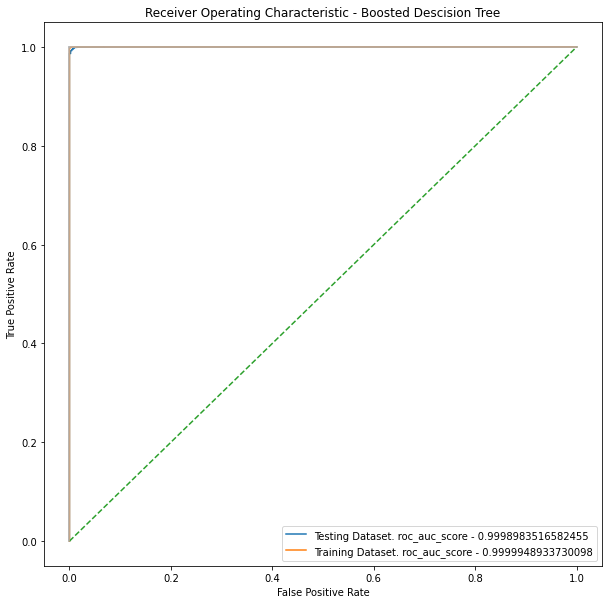

Model complete for, jpsi_mu_k_swap


C:\Windows\Temp\ipykernel_6392\1735490177.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dataset[range1]


['mu_minus_ProbNNpi', 'mu_minus_ProbNNmu', 'Pi_ProbNNpi', 'Pi_ProbNNmu', 'costhetal']
[0]	validation_0-logloss:0.55516


d:\Languages\Python\Python39\lib\site-packages\xgboost\core.py:568: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-logloss:0.43899
[2]	validation_0-logloss:0.34332
[3]	validation_0-logloss:0.26602
[4]	validation_0-logloss:0.20465
[5]	validation_0-logloss:0.15651
[6]	validation_0-logloss:0.11934
[7]	validation_0-logloss:0.09085
[8]	validation_0-logloss:0.06926
[9]	validation_0-logloss:0.05307
[10]	validation_0-logloss:0.04089
[11]	validation_0-logloss:0.03180
[12]	validation_0-logloss:0.02500
[13]	validation_0-logloss:0.01996
[14]	validation_0-logloss:0.01613
[15]	validation_0-logloss:0.01336
[16]	validation_0-logloss:0.01130
[17]	validation_0-logloss:0.00972
[18]	validation_0-logloss:0.00860
[19]	validation_0-logloss:0.00777
[20]	validation_0-logloss:0.00710
[21]	validation_0-logloss:0.00670
[22]	validation_0-logloss:0.00635
[23]	validation_0-logloss:0.00614
[24]	validation_0-logloss:0.00597
[25]	validation_0-logloss:0.00588
[26]	validation_0-logloss:0.00580
[27]	validation_0-logloss:0.00576
[28]	validation_0-logloss:0.00571
[29]	validation_0-logloss:0.00568
[30]	validation_0-loglo

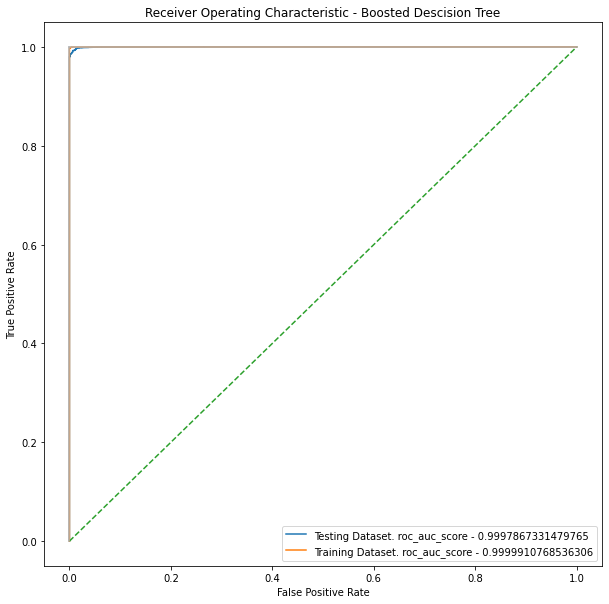

Model complete for, jpsi_mu_pi_swap


C:\Windows\Temp\ipykernel_6392\1735490177.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dataset[range1]


['K_ProbNNk', 'K_ProbNNpi', 'Pi_ProbNNk', 'Pi_ProbNNpi', 'Pi_ProbNNp']


d:\Languages\Python\Python39\lib\site-packages\xgboost\core.py:568: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.55874
[1]	validation_0-logloss:0.44585
[2]	validation_0-logloss:0.35318
[3]	validation_0-logloss:0.27864
[4]	validation_0-logloss:0.21955
[5]	validation_0-logloss:0.17355
[6]	validation_0-logloss:0.13799
[7]	validation_0-logloss:0.11102
[8]	validation_0-logloss:0.09067
[9]	validation_0-logloss:0.07540
[10]	validation_0-logloss:0.06393
[11]	validation_0-logloss:0.05542
[12]	validation_0-logloss:0.04912
[13]	validation_0-logloss:0.04446
[14]	validation_0-logloss:0.04104
[15]	validation_0-logloss:0.03845
[16]	validation_0-logloss:0.03657
[17]	validation_0-logloss:0.03514
[18]	validation_0-logloss:0.03418
[19]	validation_0-logloss:0.03345
[20]	validation_0-logloss:0.03291
[21]	validation_0-logloss:0.03253
[22]	validation_0-logloss:0.03225
[23]	validation_0-logloss:0.03208
[24]	validation_0-logloss:0.03193
[25]	validation_0-logloss:0.03183
[26]	validation_0-logloss:0.03175
[27]	validation_0-logloss:0.03166
[28]	validation_0-logloss:0.03163
[29]	validation_0-loglos

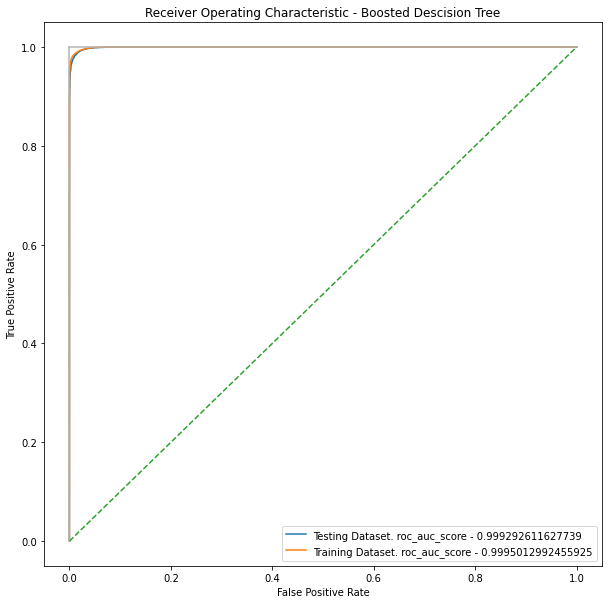

Model complete for, k_pi_swap


C:\Windows\Temp\ipykernel_6392\1735490177.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dataset[range1]


['Pi_ProbNNk', 'Pi_ProbNNpi', 'Pi_ProbNNp', 'Pi_PT', 'B0_M', 'Kstar_M', 'costhetak']


d:\Languages\Python\Python39\lib\site-packages\xgboost\core.py:568: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.55701
[1]	validation_0-logloss:0.44246
[2]	validation_0-logloss:0.34812
[3]	validation_0-logloss:0.27207
[4]	validation_0-logloss:0.21186
[5]	validation_0-logloss:0.16454
[6]	validation_0-logloss:0.12813
[7]	validation_0-logloss:0.10021
[8]	validation_0-logloss:0.07903
[9]	validation_0-logloss:0.06312
[10]	validation_0-logloss:0.05116
[11]	validation_0-logloss:0.04218
[12]	validation_0-logloss:0.03558
[13]	validation_0-logloss:0.03075
[14]	validation_0-logloss:0.02709
[15]	validation_0-logloss:0.02427
[16]	validation_0-logloss:0.02222
[17]	validation_0-logloss:0.02073
[18]	validation_0-logloss:0.01967
[19]	validation_0-logloss:0.01889
[20]	validation_0-logloss:0.01823
[21]	validation_0-logloss:0.01780
[22]	validation_0-logloss:0.01740
[23]	validation_0-logloss:0.01709
[24]	validation_0-logloss:0.01695
[25]	validation_0-logloss:0.01684
[26]	validation_0-logloss:0.01671
[27]	validation_0-logloss:0.01661
[28]	validation_0-logloss:0.01655
[29]	validation_0-loglos

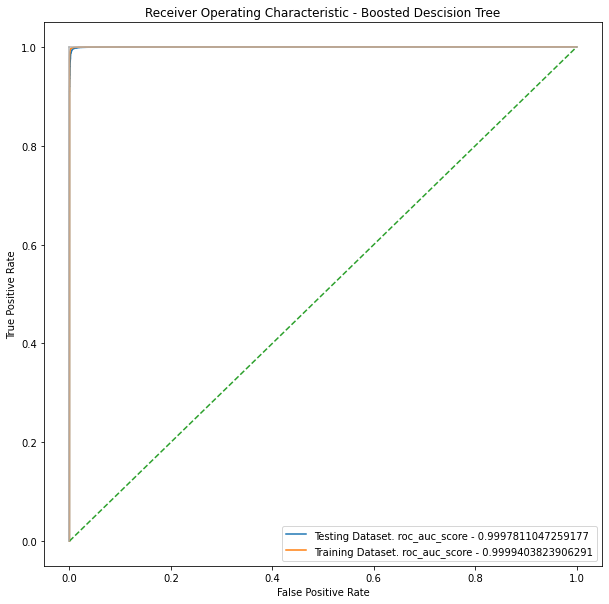

Model complete for, phimumu


C:\Windows\Temp\ipykernel_6392\1735490177.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dataset[range1]


['K_ProbNNk', 'K_ProbNNp', 'Pi_ProbNNk', 'Pi_ProbNNpi', 'B0_M', 'B0_OWNPV_Y']


d:\Languages\Python\Python39\lib\site-packages\xgboost\core.py:568: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.55738
[1]	validation_0-logloss:0.44319
[2]	validation_0-logloss:0.34900
[3]	validation_0-logloss:0.27265
[4]	validation_0-logloss:0.21189
[5]	validation_0-logloss:0.16406
[6]	validation_0-logloss:0.12706
[7]	validation_0-logloss:0.09857
[8]	validation_0-logloss:0.07697
[9]	validation_0-logloss:0.06040
[10]	validation_0-logloss:0.04790
[11]	validation_0-logloss:0.03848
[12]	validation_0-logloss:0.03126
[13]	validation_0-logloss:0.02592
[14]	validation_0-logloss:0.02184
[15]	validation_0-logloss:0.01885
[16]	validation_0-logloss:0.01653
[17]	validation_0-logloss:0.01485
[18]	validation_0-logloss:0.01363
[19]	validation_0-logloss:0.01256
[20]	validation_0-logloss:0.01189
[21]	validation_0-logloss:0.01135
[22]	validation_0-logloss:0.01084
[23]	validation_0-logloss:0.01053
[24]	validation_0-logloss:0.01021
[25]	validation_0-logloss:0.00995
[26]	validation_0-logloss:0.00981
[27]	validation_0-logloss:0.00967
[28]	validation_0-logloss:0.00959
[29]	validation_0-loglos

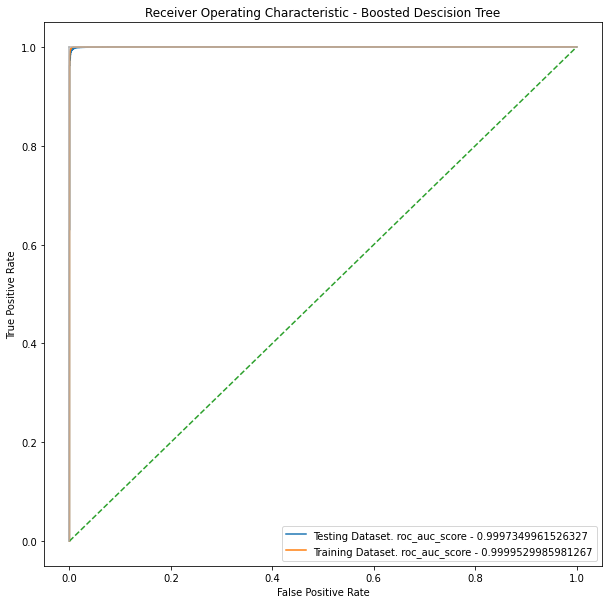

Model complete for, pKmumu_piTok_kTop


C:\Windows\Temp\ipykernel_6392\1735490177.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dataset[range1]


['Pi_ProbNNk', 'Pi_ProbNNpi', 'Pi_ProbNNp', 'Pi_P', 'Pi_PE', 'B0_M', 'Kstar_M', 'B0_OWNPV_Y']
[0]	validation_0-logloss:0.55649


d:\Languages\Python\Python39\lib\site-packages\xgboost\core.py:568: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-logloss:0.44138
[2]	validation_0-logloss:0.34648
[3]	validation_0-logloss:0.26993
[4]	validation_0-logloss:0.20890
[5]	validation_0-logloss:0.16112
[6]	validation_0-logloss:0.12407
[7]	validation_0-logloss:0.09577
[8]	validation_0-logloss:0.07438
[9]	validation_0-logloss:0.05826
[10]	validation_0-logloss:0.04613
[11]	validation_0-logloss:0.03705
[12]	validation_0-logloss:0.03034
[13]	validation_0-logloss:0.02529
[14]	validation_0-logloss:0.02156
[15]	validation_0-logloss:0.01862
[16]	validation_0-logloss:0.01659
[17]	validation_0-logloss:0.01499
[18]	validation_0-logloss:0.01378
[19]	validation_0-logloss:0.01295
[20]	validation_0-logloss:0.01225
[21]	validation_0-logloss:0.01177
[22]	validation_0-logloss:0.01136
[23]	validation_0-logloss:0.01108
[24]	validation_0-logloss:0.01092
[25]	validation_0-logloss:0.01075
[26]	validation_0-logloss:0.01064
[27]	validation_0-logloss:0.01060
[28]	validation_0-logloss:0.01053
[29]	validation_0-logloss:0.01051
[30]	validation_0-loglo

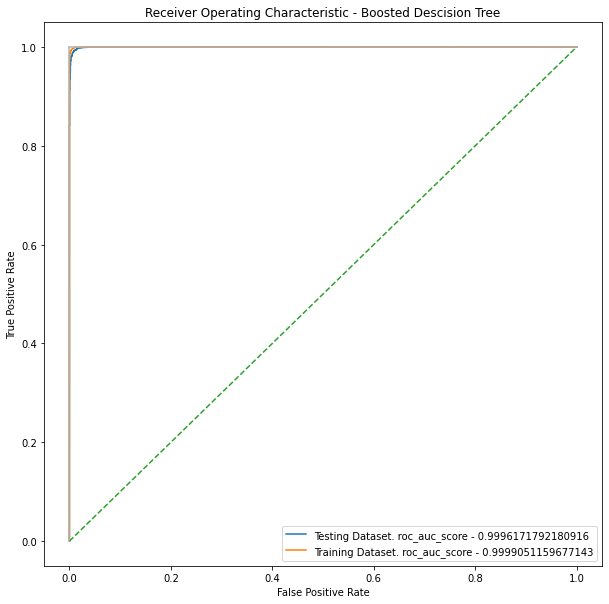

Model complete for, pKmumu_piTop


C:\Windows\Temp\ipykernel_6392\1735490177.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dataset[range1]


['Pi_PT', 'Pi_PX', 'Pi_IPCHI2_OWNPV', 'B0_M', 'B0_ENDVERTEX_CHI2', 'costhetak', 'B0_OWNPV_Y']


d:\Languages\Python\Python39\lib\site-packages\xgboost\core.py:568: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.55671
[1]	validation_0-logloss:0.44215
[2]	validation_0-logloss:0.34787
[3]	validation_0-logloss:0.27176
[4]	validation_0-logloss:0.21144
[5]	validation_0-logloss:0.16408
[6]	validation_0-logloss:0.12763
[7]	validation_0-logloss:0.09957
[8]	validation_0-logloss:0.07838
[9]	validation_0-logloss:0.06224
[10]	validation_0-logloss:0.05030
[11]	validation_0-logloss:0.04130
[12]	validation_0-logloss:0.03457
[13]	validation_0-logloss:0.02967
[14]	validation_0-logloss:0.02600
[15]	validation_0-logloss:0.02332
[16]	validation_0-logloss:0.02137
[17]	validation_0-logloss:0.01990
[18]	validation_0-logloss:0.01873
[19]	validation_0-logloss:0.01794
[20]	validation_0-logloss:0.01734
[21]	validation_0-logloss:0.01688
[22]	validation_0-logloss:0.01658
[23]	validation_0-logloss:0.01627
[24]	validation_0-logloss:0.01604
[25]	validation_0-logloss:0.01593
[26]	validation_0-logloss:0.01579
[27]	validation_0-logloss:0.01565
[28]	validation_0-logloss:0.01555
[29]	validation_0-loglos

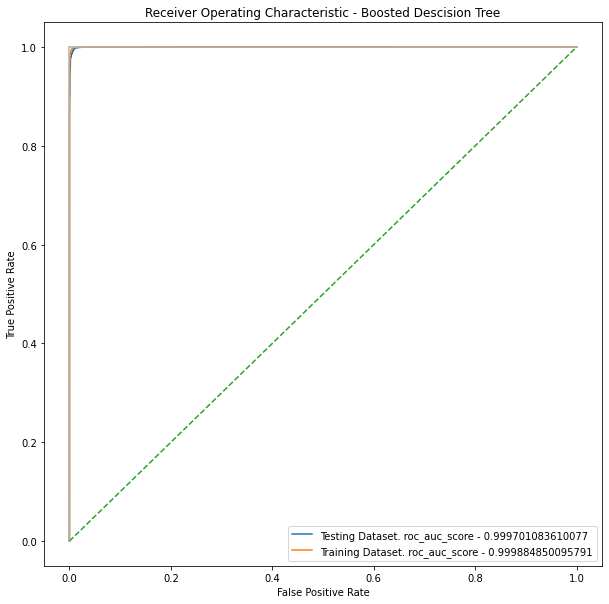

Model complete for, Kmumu


C:\Windows\Temp\ipykernel_6392\1735490177.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dataset[range1]


['Pi_PT', 'Pi_PX', 'Pi_IPCHI2_OWNPV', 'B0_M', 'B0_ENDVERTEX_CHI2', 'Kstar_M', 'Kstar_ENDVERTEX_CHI2']
[0]	validation_0-logloss:0.55845


d:\Languages\Python\Python39\lib\site-packages\xgboost\core.py:568: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
d:\Languages\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-logloss:0.44560
[2]	validation_0-logloss:0.35294
[3]	validation_0-logloss:0.27813
[4]	validation_0-logloss:0.21888
[5]	validation_0-logloss:0.17248
[6]	validation_0-logloss:0.13672
[7]	validation_0-logloss:0.10908
[8]	validation_0-logloss:0.08807
[9]	validation_0-logloss:0.07215
[10]	validation_0-logloss:0.06035
[11]	validation_0-logloss:0.05139
[12]	validation_0-logloss:0.04509
[13]	validation_0-logloss:0.04014
[14]	validation_0-logloss:0.03661
[15]	validation_0-logloss:0.03417
[16]	validation_0-logloss:0.03229
[17]	validation_0-logloss:0.03084
[18]	validation_0-logloss:0.02981
[19]	validation_0-logloss:0.02900
[20]	validation_0-logloss:0.02849
[21]	validation_0-logloss:0.02810
[22]	validation_0-logloss:0.02776
[23]	validation_0-logloss:0.02750
[24]	validation_0-logloss:0.02735
[25]	validation_0-logloss:0.02735
[26]	validation_0-logloss:0.02729
[27]	validation_0-logloss:0.02725
[28]	validation_0-logloss:0.02721
[29]	validation_0-logloss:0.02724
[30]	validation_0-loglo

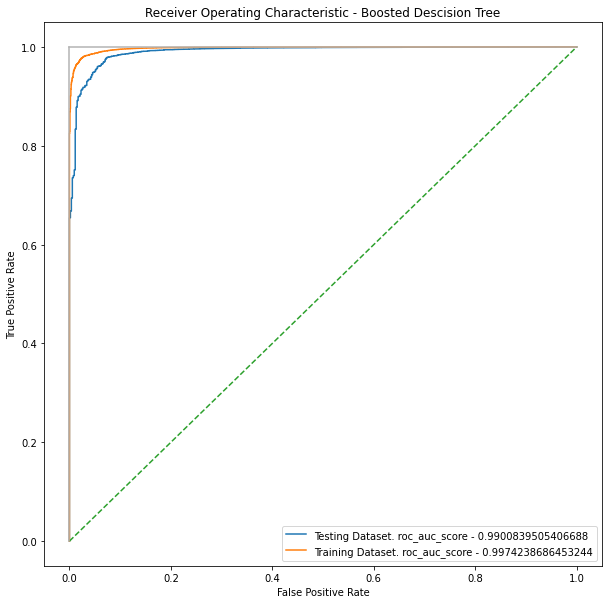

Model complete for, Kstarp_pi0


In [49]:
#Running with optimized parameters

def remove_columns(dataset, reject_rows = []):
    #'B0_M', 'J_psi_M', 'q2','Kstar_M'
    dataset_modified = dataset.copy()
    dataset_modified.drop(columns=['Unnamed: 0.1','Unnamed: 0', 'year', 'B0_ID', 'B0_ENDVERTEX_NDOF','J_psi_ENDVERTEX_NDOF', 'Kstar_ENDVERTEX_NDOF'], inplace=True)
    if 'Unnamed: 0.2' in dataset_modified.columns:
        dataset_modified.drop(columns=['Unnamed: 0.2'], inplace=True)

    columns_list = dataset_modified.columns.tolist()
    for x in total_data.columns:
        if x in columns_list and x not in reject_rows:
            dataset_modified.drop(columns=[x],inplace = True)
    
    return dataset_modified

def train_model(X_train,y_train,X_test,y_test,name_of_model):
    f = open('Optimized_Parameters/{}.json'.format(name_of_model))
    best_hyperparams = json.load(f)
    best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])
    model = xgb.XGBClassifier(**best_hyperparams)

    model = xgb.XGBClassifier('binary:logistic', missing = np.nan, seed = 42, max_delta_step = 1)

    model.fit(X_train,
            y_train,
            verbose = True,
            early_stopping_rounds = 10,
            eval_metric = 'logloss',
            eval_set = [(X_test,y_test)]
            )

    model.save_model('Peaking_Models_Separate/peaking_model_'+name_of_model+'_removed_q2_range.model')
    
    print(X_train.columns)

    return model


# TRAINING THE PEAKING MODEL
background_models = [jpsi_mu_k_swap,jpsi_mu_pi_swap,k_pi_swap,phimumu,pKmumu_piTok_kTop,pKmumu_piTop,Kmumu,Kstarp_pi0]
string_background_models = ['jpsi_mu_k_swap','jpsi_mu_pi_swap','k_pi_swap','phimumu','pKmumu_piTok_kTop','pKmumu_piTop','Kmumu','Kstarp_pi0']

signal.loc[:, "target"] = 1
signal = q2_ranges(signal)
for idx,x in enumerate(background_models):
    x.loc[:, "target"] = 0

    signal = q2_ranges(signal)
    x = q2_ranges(x)

    signal_clean = remove_columns(signal, RowRejector(string_background_models[idx]))
    background_clean = remove_columns(x, RowRejector(string_background_models[idx]))

    #We then combine the entire dataset.
    combine = pd.concat((signal_clean,background_clean), ignore_index=True, axis=0)
    #We then shuffle the order and relabel the index.
    combine = combine.sample(frac=1)
    combine = combine.reset_index(drop=True)



    #CREATING THE TRAINING AND TEST DATA
    seed = 42
    test_size = 0.2
    y = combine['target']
    X = combine.drop(columns=['target'])
    #Creating the three different data sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed, stratify = y)
    print(X_train.columns.tolist())
    model = train_model(X_train,y_train,X_test,y_test,string_background_models[idx])

    plt.subplots(1, figsize=(10,10))
    plt.title('Receiver Operating Characteristic - Boosted Descision Tree')
    y_score_test = model.predict_proba(X_test)[:,1]
    y_score_train = model.predict_proba(X_train)[:,1]
    false_positive_rate_test, true_positive_rate_test, threshold_train = roc_curve(y_test, y_score_test)
    false_positive_rate_train, true_positive_rate_train, threshold_train = roc_curve(y_train, y_score_train)
    plt.plot(false_positive_rate_test, true_positive_rate_test, label = "Testing Dataset. roc_auc_score - {}".format(roc_auc_score(y_test, y_score_test)))
    plt.plot(false_positive_rate_train, true_positive_rate_train, label = "Training Dataset. roc_auc_score - {}".format(roc_auc_score(y_train, y_score_train)))
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    plt.savefig("Overfitting_Graphs_Optimized/Overfitting_separate_peaking_{}.jpg".format(string_background_models[idx]), bbox_inches="tight", pad_inches=0, format="jpg", dpi=600)
    plt.show()

    print("Model complete for,",string_background_models[idx])

C:\Windows\Temp\ipykernel_6392\1735490177.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dataset[range1]


Peaking_Models_Separate\peaking_model_jpsi_mu_k_swap_removed_q2_range.model
Peaking_Models_Separate\peaking_model_jpsi_mu_pi_swap_removed_q2_range.model
Peaking_Models_Separate\peaking_model_Kmumu_removed_q2_range.model
Peaking_Models_Separate\peaking_model_Kstarp_pi0_removed_q2_range.model
Peaking_Models_Separate\peaking_model_k_pi_swap_removed_q2_range.model
Peaking_Models_Separate\peaking_model_phimumu_removed_q2_range.model
Peaking_Models_Separate\peaking_model_pKmumu_piTok_kTop_removed_q2_range.model
Peaking_Models_Separate\peaking_model_pKmumu_piTop_removed_q2_range.model


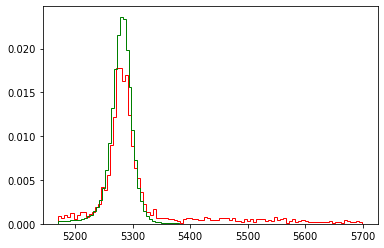

In [53]:
def exponential(x,A,d):
    exponential = A*np.exp(-x/d)
    return exponential

def gaussian(x,A,mu,std):
    gaussian = A*np.exp(-(x-mu)**2/(2*std**2))
    return gaussian

def gaussian_exponential(x,A1,mu,std,A2,d):
    exponential_1 = exponential(x,A2,d)
    gaussian_1 = gaussian(x,A1,mu,std)
    f = exponential_1+gaussian_1
    return f

# def two_gaussian_exponential(x,A1,mu1,std1,A2,d,A3,std2):
#     exponential_1 = exponential(x,A2,d)
#     gaussian_1 = gaussian(x,A1,mu1,std1)
#     gaussian_2 = gaussian(x,A3,mu1,std1)
#     f = exponential_1+gaussian_1+gaussian_2
#     return f

#For some reason writing each out is more accurate?
def two_gaussian_exponential(x,A1,mu1,std1,A2,d,A3,std2):
    exponential_1 = A2*np.exp(-x/d)
    gaussian_1 = A1*np.exp(-(x-mu1)**2/(2*std1**2))
    gaussian_2 = A3*np.exp(-(x-mu1)**2/(2*std2**2))
    f = exponential_1+gaussian_1+gaussian_2
    return f



def fit(x,y):
    '''
    Returns the params which decribe the expotenial and guassians which best fit the data.
    '''
    #Trial and error inital guess, I found that these numbers seemed to work best.
    p00=[0.01,5275,15]

    #guesses the parameters for a single gaussian
    par0, cov0 = curve_fit(gaussian,x,y,p0=p00)

    #uses the guesses for the gaussian, to find a more precise guess for a guassian and exponential. Again trail and error used for inital guess.
    p01=list(par0)+[1.7e5,1.9e2]
    par1, cov1 = curve_fit(gaussian_exponential,x,y,p0=p01)

    #Uses previous guesses to find the fit for two gaussians and an expoential.
    p02=list(par1)+[par1[0]]+[par1[2]]

    return curve_fit(two_gaussian_exponential,x,y,p0=p02)

def plot(x,y,dataset,param,bins_n,y_0,y_exp, name_of_graph,dataset_name):
    #Ploting graph
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    x_smooth = np.linspace(min(x),max(x),10000)
    ax.plot(x,y, ".", color='green',label = dataset_name)

    n, bins = np.histogram(dataset['B0_M'],bins = bins_n)
    yerr = np.divide(np.sqrt(n), n,)* y
    ax.errorbar(x,y, yerr = yerr , ls = 'none', color = 'black', elinewidth=1)
    ax.plot(x_smooth,two_gaussian_exponential(x_smooth,*param), color='green', label = "Fitted (2 Gaussian's + Exponential)")
    ax.fill_between(x,y_0,y_exp, color = 'orange',label = 'Combinatorial Background')

    # Layout of graph - From Nick Khoze. ----------------------

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # Switch off ticks
    ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = ax.get_yticks()
    for tick in vals:
        ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Format y-axis label
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

    #----------------------------------------------------------
    plt.xlabel(r'm($K^{+}\pi^{-}\mu^{+}\mu^{-}$) [MeV/$c^{2}$]')
    plt.ylabel(r'Frequency')
    plt.title(name_of_graph)
    plt.ylim(0)
    plt.legend()
    plt.savefig('B0_plot_graph/'+str(name_of_graph)+'.jpg', bbox_inches="tight", pad_inches=0, format="jpg", dpi=600)
    plt.show()
def remove_columns(dataset, reject_rows = []):
    #'B0_M', 'J_psi_M', 'q2','Kstar_M'
    dataset_modified = dataset.copy()
    dataset_modified.drop(columns=['Unnamed: 0.1','Unnamed: 0', 'year', 'B0_ID', 'B0_ENDVERTEX_NDOF','J_psi_ENDVERTEX_NDOF', 'Kstar_ENDVERTEX_NDOF'], inplace=True)
    if 'Unnamed: 0.2' in dataset_modified.columns:
        dataset_modified.drop(columns=['Unnamed: 0.2'], inplace=True)

    columns_list = dataset_modified.columns.tolist()
    for x in total_data.columns:
        if x in columns_list and x not in reject_rows:
            dataset_modified.drop(columns=[x],inplace = True)
    
    return dataset_modified


def high_corrolation_list_peaking_together(num):
    corrolation = pd.read_csv('Peaking_Together_Correlation/continuous_f1_score_peaking_together.csv')
    cols = corrolation.columns.tolist()
    values = {}
    for x in cols:
        values[x] = float(corrolation[x])

    values = dict(sorted(values.items(), key=lambda item: item[1], reverse=True))
    array_list = []
    for idx, key in enumerate(values):
        if(idx > num-1):
            array_list.append(key)
    return array_list

def high_corrolation_list_comb(num):
    corrolation = pd.read_csv('Comb_Correlation/continuous_f1_score_comb.csv')
    cols = corrolation.columns.tolist()
    values = {}
    for x in cols:
        values[x] = float(corrolation[x])

    values = dict(sorted(values.items(), key=lambda item: item[1], reverse=True))
    array_list = []
    for idx, key in enumerate(values):
        if(idx > num-1):
            array_list.append(key)
    return array_list


total_data = pd.read_csv('../data/total_dataset.csv', on_bad_lines='skip')
#signal_ml = pd.read_csv('Signal_ML_Combo_removed_only.csv')
s_c_dataset = apply_all_selection(total_data)

#------------------------------
'''
Loads in the peaking model and comb models... and applies them.
'''
#boolean controls if the peaking model used is the based off multiple peaking models or just one combined one.
separate = True
directory = 'Peaking_Models_Separate'
training = s_c_dataset.copy()

i = 0

NAMES = ['jpsi_mu_k_swap','jpsi_mu_pi_swap','Kmumu','Kstarp_pi0','k_pi_swap','phimumu','pKmumu_piTok_kTop','pKmumu_piTop']

if separate == True:
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            print(f)
            model = xgb.XGBClassifier()
            model.load_model(f)
            temp_full = training
            training = remove_columns(training, RowRejector(NAMES[i]))
            ypred = model.predict(training)
            training = temp_full.loc[ypred == 1]
            i += 1
elif separate == False:
    peaking_model = xgb.XGBClassifier()
    peaking_model.load_model('Peaking_Models_Together/peaking_model_trained_together_removed_q2_range_13_features.model')
    temp_full = training
    remove_col_list = high_corrolation_list_peaking_together(13)
    training = remove_columns(training, remove_col_list)
    ypred = peaking_model.predict(training)
    training = temp_full.loc[ypred == 1]


model = xgb.XGBClassifier()
model.load_model('Comb_Model/comb_model_5350_removed_q2_range_29_features.model')

peaking_removed_signal = training.copy()


temp_full = s_c_dataset.copy()

training = remove_columns(temp_full, RowRejector("combo"))
ypred = model.predict(training)

signal_ml = temp_full.loc[ypred == 1]


#writes the ml signal to file (peaking and comb applied).
#signal_ml.to_csv('ML_SIGNAL_BDT.csv')
#---------------------------------------------------

bins_n = 100

#Calculates histogram for the selection criteria applied dataset.
n_b0_total,bin_edges_b0_total = np.histogram(s_c_dataset['B0_M'],bins = bins_n, density = True)
mid_bin_total = (bin_edges_b0_total[1:]+bin_edges_b0_total[:-1])*0.5

#Calculates histogram for the ml signal dataset.
n_b0_signal,bin_edges_b0_signal = np.histogram(signal_ml['B0_M'],bins = bins_n, density = True)
mid_bin_signal = (bin_edges_b0_signal[1:]+bin_edges_b0_signal[:-1])*0.5

#Calculates histogram for the peaking model removed dataset.
n_b0_peaking,bin_edges_b0_peaking = np.histogram(temp_full['B0_M'],bins = bins_n, density = True)
mid_bin_peaking = (bin_edges_b0_peaking[1:]+bin_edges_b0_peaking[:-1])*0.5

#calculates the parameters used for the fit.
x_total, y_total = mid_bin_total,n_b0_total
x_signal, y_signal = mid_bin_signal,n_b0_signal
x_peaking, y_peaking = mid_bin_peaking,n_b0_peaking

#par_total,cov2_total = fit(x_total,y_total)
#par_signal,cov2_signal = fit(x_signal,y_signal)
#par_peaking,cov2_peaking = fit(x_peaking,y_peaking)

#Gets the exponential terms
#y_exp_total=exponential(x_total,par_total[3],par_total[4])
#y_0_total=np.zeros(len(y_exp_total))

#y_exp_signal=exponential(x_signal,par_signal[3],par_signal[4])
#y_0_signal=np.zeros(len(y_exp_signal))

#y_exp_peaking=exponential(x_peaking,par_peaking[3],par_peaking[4])
#y_0_peaking=np.zeros(len(y_exp_peaking))

#plot(x_total,y_total,s_c_dataset,list(par_total),bins_n,y_0_total,y_exp_total, 'Total Dataset (selection criteria applied)','Total dataset (SC applied)')
#plot(x_signal,y_signal,signal_ml,list(par_signal),bins_n,y_0_signal,y_exp_signal, 'ML Signal (Combo + Peaking removed)','Ml Signal')
#plot(x_peaking,y_peaking,temp_full,list(par_peaking),bins_n,y_0_peaking,y_exp_peaking, 'ML Signal (Peaking removed)','Ml Signal')

datamaybe = pd.concat((signal_ml, peaking_removed_signal), ignore_index=True, axis=0)
#We then shuffle the order and relabel the index.
# datamaybe = datamaybe.sample(frac=1)
# datamaybe = datamaybe.reset_index(drop=True)
datamaybe = datamaybe.drop_duplicates()
datamaybe.to_csv('ML_SIGNAL_BDT.csv')



plt.hist(datamaybe['B0_M'], color="white", ec="Red",bins = bins_n, density = True, histtype='step')
plt.hist(signal["B0_M"], color="white", ec="Green",bins = bins_n, density = True, histtype='step')
plt.show()

In [54]:
print(len(datamaybe))

3366


In [52]:
removed_dup = datamaybe.drop_duplicates()
print(len(removed_dup))

3366


In [22]:
print(len(signal_ml))
signal_ml.head()

1929


,Unnamed: 0.1,Unnamed: 0,mu_plus_ProbNNk,mu_plus_ProbNNpi,mu_plus_ProbNNmu,mu_plus_ProbNNe,mu_plus_ProbNNp,mu_plus_P,mu_plus_PT,mu_plus_ETA,...,B0_FD_OWNPV,B0_ID,B0_ENDVERTEX_X,B0_ENDVERTEX_Y,B0_ENDVERTEX_Z,q2,phi,costhetal,costhetak,year
109,109,109,0.378621,0.162445,0.753815,2.504024e-08,3.189502e-02,30227.09,985.825558,4.115896,...,32.552270,-511,-0.445291,0.597415,-0.231098,15.460344,-2.122090,0.334228,0.303523,2016
145,145,145,0.000085,0.004165,0.994343,2.708624e-06,8.680513e-07,17310.98,4145.567123,2.107793,...,9.520838,511,-0.634874,-0.431535,110.248806,15.388858,0.292134,0.171057,-0.547389,2016
324,324,324,0.000670,0.025608,0.997226,2.165724e-06,5.216134e-07,56806.37,2327.936725,3.887393,...,2.506385,-511,0.937456,-0.235167,-26.706372,7.548473,-3.127781,-0.024611,0.696449,2016
446,446,446,0.000038,0.006349,0.997914,2.688242e-06,9.123940e-07,27106.97,4800.273910,2.416331,...,13.282555,-511,0.460237,-1.594115,22.552151,16.843092,-2.276971,0.918008,0.725331,2016
617,617,617,0.072232,0.075307,0.968133,9.118348e-07,3.090990e-02,3439.55,880.469494,2.038988,...,11.346346,-511,0.832977,1.383876,-10.606833,6.080476,-2.191823,-0.240562,-0.915371,2016


In [24]:
print(len(temp_full))
temp_full.head()

8701


,Unnamed: 0.1,Unnamed: 0,mu_plus_ProbNNk,mu_plus_ProbNNpi,mu_plus_ProbNNmu,mu_plus_ProbNNe,mu_plus_ProbNNp,mu_plus_P,mu_plus_PT,mu_plus_ETA,...,B0_FD_OWNPV,B0_ID,B0_ENDVERTEX_X,B0_ENDVERTEX_Y,B0_ENDVERTEX_Z,q2,phi,costhetal,costhetak,year
22,22,22,0.000045,0.114083,0.993339,4.071954e-07,0.000001,26159.842567,3551.228879,2.685440,...,13.722376,511,1.730300,0.354400,37.835100,16.213952,0.866022,0.837496,0.047059,2016
51,51,51,0.118682,0.011838,0.990396,8.931514e-06,0.007702,136266.330000,6866.334473,3.680493,...,10.394984,-511,1.425570,-0.180607,44.379150,1.006305,-0.992421,0.621414,0.437520,2016
81,81,81,0.000068,0.044498,0.997830,2.188930e-06,0.000001,31657.370000,2822.076944,3.108652,...,12.637340,-511,0.697296,-1.110749,89.442586,3.965415,3.019785,-0.438920,-0.897619,2016
109,109,109,0.378621,0.162445,0.753815,2.504024e-08,0.031895,30227.090000,985.825558,4.115896,...,32.552270,-511,-0.445291,0.597415,-0.231098,15.460344,-2.122090,0.334228,0.303523,2016
124,124,124,0.003185,0.005551,0.971649,1.071599e-05,0.000096,10949.800000,1101.630261,2.987137,...,4.827200,511,0.474784,0.329551,-6.508859,5.449862,-1.647691,-0.663278,-0.897021,2016


In [20]:
print(len(training))

2659


In [25]:

print(len(peaking_removed_signal))

2659
